In [3]:
# Data procesing, description and ploting
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tableone import TableOne as to
from IPython.display import display
import pickle

# Feature selection 
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, mutual_info_classif, SelectFromModel, RFE 
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier 
from sklearn.linear_model import LassoCV, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score
from feature_engine.selection import MRMR


# Oversampling 
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.combine import SMOTETomek

# Classification 
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, balanced_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold,cross_val_score, train_test_split 
import xgboost as xgb
import optuna
import shap
import scipy
from scipy.stats import randint, uniform


# Load data

In [4]:
# Load the preprocessed training data 
x_train = pd.read_excel('E:\TFM Marta\Codis\Preprocessed_data_train_v4_30.70.xlsx')
y_train = pd.read_excel('E:\TFM Marta\Codis\y_train_v4_30.70.xlsx')
y_train = y_train['RESPONSE']
x_train = x_train.drop(columns='Unnamed: 0')

# Load the preprocessed test data 
x_test = pd.read_excel('E:\TFM Marta\Codis\Preprocessed_data_test_v4_30.70.xlsx')
y_test = pd.read_excel('E:\TFM Marta\Codis\y_test_v4_30.70.xlsx')
y_test = y_test['RESPONSE']
x_test = x_test.drop(columns='Unnamed: 0')

# Variance filter

In [5]:
# Remove all features with zero variance
var = VarianceThreshold(threshold=0)  

# Apply the variance threshold to the training data to filter out low-variance features
x_train_reduced = var.fit_transform(x_train)
x_train_reduced = pd.DataFrame(x_train_reduced, columns=x_train.columns[var.get_support()])
print(f"Remaining features: {x_train_reduced.shape[1]}")
x_train = x_train_reduced

# Apply the same transformation to the test data
x_test_reduced = var.transform(x_test)
x_test_reduced = pd.DataFrame(x_test_reduced, columns=x_test.columns[var.get_support()])
x_test = x_test_reduced

# Defining clinical and radiomic variables

In [6]:
clinical_variables = ['DOSIS TOTAL(GY)', 'SESIONES', 'DOSIS/FRACCIÓN', 'EDAD', 'SEXO_Mujer',
       'TABAQUISMO_No', 'TABAQUISMO_Si', 'ENOLISMO_No', 'ENOLISMO_Si', 'DM_Si',
       'HTA_Si', 'DLP_Si', 'PATOLOGIA PULMONAR_Si', 'PATOLOGIA CARDÍACA_Si',
       'ANTC ONCO_Si', 'Tipo de lesion _PD pulmón ',
       'Tipo de lesion _Primario sin antc', 'HISTOLOGIA_CEC',
       'HISTOLOGIA_NoAP', 'HISTOLOGIA_Otros', 'LOCALIZACIÓN _LII',
       'LOCALIZACIÓN _LMD', 'LOCALIZACIÓN _LSD', 'LOCALIZACIÓN _LSI']

x_train_clinical = x_train[clinical_variables]
print(x_train_clinical.shape)

x_train_radiomic = x_train.drop(columns=clinical_variables)
print(x_train_radiomic.shape)

(95, 24)
(95, 1557)


# Feature selection 

In [ ]:
def lasso_feature_selection(X_train, y_train):
    lasso_cv = LassoCV(cv=5, random_state=2024, max_iter=500)
    lasso_cv.fit(X_train, y_train)
    # Select features where the coefficient is non-zero
    lasso_selected = lasso_cv.coef_ != 0
    selected_features = X_train.columns[lasso_selected]
    return selected_features

def rf_feature_selection(X_train, y_train, top_n=10):
    rf = RandomForestClassifier(n_estimators=100, random_state=2024)
    rf.fit(X_train, y_train)
    importances = rf.feature_importances_
    # Get the top N important features
    feature_importances_df = pd.DataFrame({
        'feature': X_train.columns,
        'importance': importances
    })
    selected_features = feature_importances_df.sort_values(by='importance', ascending=False).head(top_n)['feature']
    return selected_features

def anova_feature_selection(X_train, y_train, threshold=0.05, top_n=10):
    F_scores, p_values = f_classif(X_train, y_train)
    # Select features with p-value less than threshold and sort by F-score
    selected_indices = np.where(p_values <= threshold)[0]  # Índices filtrados por p-value
    sorted_indices = np.argsort(F_scores[selected_indices])[-top_n:][::-1]  # Ordenar por F-score
    selected_features = X_train.columns[selected_indices[sorted_indices]]  # Convertir a nombres
    return selected_features

def mrmr_feature_selection(X_train, y_train, method="MIQ", top_n=10):
    mrmr_selector = MRMR(method=method, random_state=2024)
    mrmr_selector.fit(X_train, y_train)
    # Get the top N relevant features
    selected_features = pd.Series(mrmr_selector.relevance_, index=mrmr_selector.variables_).sort_values(ascending=False).head(top_n).index
    return selected_features


#OPTUNA
class FeatureSelectionOptuna:
    """
    This class implements feature selection using Optuna optimization framework.

    Parameters:

    - model (object): The predictive model to evaluate; this should be any object that implements fit() and predict() methods.
    - loss_fn (function): The loss function to use for evaluating the model performance. This function should take the true labels and the
                          predictions as inputs and return a loss value.
    - features (list of str): A list containing the names of all possible features that can be selected for the model.
    - X (DataFrame): The complete set of feature data (pandas DataFrame) from which subsets will be selected for training the model.
    - y (Series): The target variable associated with the X data (pandas Series).
    - splits (list of tuples): A list of tuples where each tuple contains two elements, the train indices and the validation indices.
    - penalty (float, optional): A factor used to penalize the objective function based on the number of features used.
    """

    def __init__(self,
                 model,
                 loss_fn,
                 features,
                 X,
                 y,
                 splits,
                 penalty=0):

        self.model = model
        self.loss_fn = loss_fn
        self.features = features
        self.X = X
        self.y = y
        self.splits = splits
        self.penalty = penalty

    def __call__(self,
                 trial: optuna.trial.Trial):

        # Select True / False for each feature
        selected_features = [trial.suggest_categorical(name, [True, False]) for name in self.features]

        # List with names of selected features
        selected_feature_names = [name for name, selected in zip(self.features, selected_features) if selected]

        # Optional: adds a penalty for the amount of features used
        n_used = len(selected_feature_names)
        total_penalty = n_used * self.penalty

        loss = 0

        for split in self.splits:
          train_idx = split[0]
          valid_idx = split[1]

          X_train = self.X.iloc[train_idx].copy()
          y_train = self.y.iloc[train_idx].copy()
          X_valid = self.X.iloc[valid_idx].copy()
          y_valid = self.y.iloc[valid_idx].copy()

          X_train_selected = X_train[selected_feature_names].copy()
          X_valid_selected = X_valid[selected_feature_names].copy()

          # Train model, get predictions and accumulate loss
          self.model.fit(X_train_selected, y_train)
          pred = self.model.predict(X_valid_selected)

          loss += self.loss_fn(y_valid, pred)

        # Take the average loss across all splits
        loss /= len(self.splits)

        # Add the penalty to the loss
        loss += total_penalty

        return loss

def optuna_feature_selection(X_train, y_train, splits, top_n=10, random_state=42):
    # Initialize FeatureSelectionOptuna with Random Forest classifier
    fs_optuna = FeatureSelectionOptuna(
        model=RandomForestClassifier(random_state=random_state),
        loss_fn=lambda y_true, y_pred: 1 - balanced_accuracy_score(y_true, y_pred),
        features=X_train.columns.tolist(),
        X=X_train,
        y=y_train,
        splits=splits,
        penalty=0.01  # Small penalty for each selected feature
    )

    # Crear un sampler con seed para reproducibilidad
    sampler = optuna.samplers.TPESampler(seed=random_state)

    # Run Optuna
    study = optuna.create_study(direction='minimize', sampler=sampler)
    study.optimize(fs_optuna, n_trials=10)

    # Best features from the best trial
    best_trial = study.best_trial
    selected_features = [name for name, selected in zip(X_train.columns, best_trial.params.values()) if selected]
    return selected_features

# Clinical pedictive models
## Clinical feature selection 

In [6]:
# Define StratifiedKFold cross-validation to ensure balanced class distribution in each split
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Generate splits for training data and target variable while preserving class distribution
splits = list(kf.split(x_train_clinical, y_train))

# Create a dictionary to store different feature selection methods applied to clinical data
clinical_feature_sets = {
        'Lasso': lasso_feature_selection(x_train_clinical, y_train),
        'ANOVA': anova_feature_selection(x_train_clinical, y_train),
        'RandomForest': rf_feature_selection(x_train_clinical, y_train),
        'MRMR_MIQ': mrmr_feature_selection(x_train_clinical, y_train, method="MIQ"),
        'MRMR_RF': mrmr_feature_selection(x_train_clinical, y_train, method="RFCQ"),    
        'Optuna': optuna_feature_selection(x_train_clinical, y_train, splits)
    }

#with open('clinical_feature_sets.pkl', 'wb') as f:
 #   pickle.dump(clinical_feature_sets, f)

c:\Users\pcbox\anaconda3\Lib\site-packages\feature_engine\selection\mrmr.py:465: RuntimeWarning: divide by zero encountered in divide
  mrmr = relevance / redundance
c:\Users\pcbox\anaconda3\Lib\site-packages\feature_engine\selection\mrmr.py:465: RuntimeWarning: invalid value encountered in divide
  mrmr = relevance / redundance
c:\Users\pcbox\anaconda3\Lib\site-packages\feature_engine\selection\mrmr.py:465: RuntimeWarning: invalid value encountered in divide
  mrmr = relevance / redundance
c:\Users\pcbox\anaconda3\Lib\site-packages\feature_engine\selection\mrmr.py:465: RuntimeWarning: invalid value encountered in divide
  mrmr = relevance / redundance
[I 2024-12-30 22:02:30,699] A new study created in memory with name: no-name-f089d462-d82d-4b97-8ebb-8929d128f585
[I 2024-12-30 22:02:31,206] Trial 0 finished with value: 0.5799450549450549 and parameters: {'DOSIS TOTAL(GY)': False, 'SESIONES': True, 'DOSIS/FRACCIÓN': True, 'EDAD': False, 'SEXO_Mujer': False, 'TABAQUISMO_No': False, 'TAB

### Presence Absence clinical features

In [7]:
# All unique features
all_features = list(set().union(*clinical_feature_sets.values())) 

# Create the presence-absence table
presence_absence_table = pd.DataFrame(index=all_features, columns=clinical_feature_sets.keys())
for method, features in clinical_feature_sets.items():
    presence_absence_table[method] = presence_absence_table.index.isin(features).astype(int)

# Total column
presence_absence_table['Total_Selected'] = presence_absence_table.sum(axis=1)

# Reorder the table 
presence_absence_table = presence_absence_table.sort_values(by='Total_Selected', ascending=False)

# Filter features selected by the majority of methods
majority_threshold = len(clinical_feature_sets) // 2 
selected_by_majority = presence_absence_table[presence_absence_table['Total_Selected'] >= majority_threshold]

# Display results
display(presence_absence_table)
print("\nFeatures selected by the majority of methods:\n", selected_by_majority.index)
#presence_absence_table.to_excel('PresenceAbsence_clinicalVariables.xlsx', index=True)


Lasso  ANOVA  RandomForest  MRMR_MIQ  MRMR_RF  \
SESIONES                        0      0             1         1        1   
TABAQUISMO_Si                   0      0             1         1        0   
ANTC ONCO_Si                    0      0             0         1        1   
DOSIS TOTAL(GY)                 0      0             1         1        1   
PATOLOGIA CARDÍACA_Si           0      1             1         0        1   
DOSIS/FRACCIÓN                  0      0             1         0        1   
EDAD                            0      0             1         0        1   
LOCALIZACIÓN _LSD               0      0             1         0        1   
PATOLOGIA PULMONAR_Si           0      0             1         1        0   
HISTOLOGIA_NoAP                 0      0             0         1        0   
DM_Si                           0      0             1         0        0   
HTA_Si                          0      0             1         0        0   
Tipo de lesion _PD pulmón       0      0             0         0        1   
HISTOLOGIA_Otros                0      0             0         1        0   
ENOLISMO_No                     0      0             0         1        0   
DLP_Si                          0      0             0         0        1   
TABAQUISMO_No                   0      0             0         0        1   
LOCALIZACIÓN _LMD               0      0             0         1        0   
HISTOLOGIA_CEC                  0      0             0         0        0   
ENOLISMO_Si                     0      0             0         1        0   

                            Optuna  Total_Selected  
SESIONES                         1               4  
TABAQUISMO_Si                    1               3  
ANTC ONCO_Si                     1               3  
DOSIS TOTAL(GY)                  0               3  
PATOLOGIA CARDÍACA_Si            0               3  
DOSIS/FRACCIÓN                   1               3  
EDAD                             0               2  
LOCALIZACIÓN _LSD                0               2  
PATOLOGIA PULMONAR_Si            0               2  
HISTOLOGIA_NoAP                  1               2  
DM_Si                            1               2  
HTA_Si                           1               2  
Tipo de lesion _PD pulmón        1               2  
HISTOLOGIA_Otros                 1               2  
ENOLISMO_No                      0               1  
DLP_Si                           0               1  
TABAQUISMO_No                    0               1  
LOCALIZACIÓN _LMD                0               1  
HISTOLOGIA_CEC                   1               1  
ENOLISMO_Si                      0               1


Features selected by the majority of methods:
 Index(['SESIONES', 'TABAQUISMO_Si', 'ANTC ONCO_Si', 'DOSIS TOTAL(GY)',
       'PATOLOGIA CARDÍACA_Si', 'DOSIS/FRACCIÓN'],
      dtype='object')


## Training and testing predictive clinical models  

In [ ]:
# Dictionary of classifiers
clfs = {
    'RandomForest': RandomForestClassifier(random_state=2024, class_weight='balanced'),
    'LogisticRegression': LogisticRegression(random_state=2024, max_iter=1000, class_weight='balanced'),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True, random_state=2024, class_weight='balanced'),
    'XGBoost': xgb.XGBClassifier(objective="binary:logistic", random_state=2024),
    'MLPC': MLPClassifier(random_state=2024)
}

# Dictionary defining scoring metrics
scoring = {
    'roc_auc': 'roc_auc',
    'balanced_accuracy': make_scorer(balanced_accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

# List to store results for each classifier 
results = []

# Stratified K-Fold cross-validation configuration
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2024)

# Iterate through each feature set
for feature_set_name, selected_features in clinical_feature_sets.items():
    if len(selected_features) != 0:
         # Select the relevant features for training and testing
         X_train = x_train[selected_features]
         X_test = x_test[selected_features]

        # Iterate through each classifier in the dictionary
         for clf_name, clf in clfs.items():
            # Perform cross-validation
             cv_results = cross_validate(
                clf, X_train, y_train, scoring=scoring, cv=cv, return_train_score=True
                )
        
            # Train the model on the training data
             clf.fit(X_train, y_train)
        
            # Generate predictions for the test set
             y_pred_prob = clf.predict_proba(X_test)[:, 1]
             y_pred_test = clf.predict(X_test)
            
             # Calculate feature importance based on the classifier
             if hasattr(clf, "feature_importances_"):
                feature_importances = clf.feature_importances_
             elif hasattr(clf, "coef_"):
                feature_importances = np.abs(clf.coef_)[0]
             else:
                explainer = shap.KernelExplainer(clf.predict_proba, X_train)
                shap_values = explainer.shap_values(X_train)
                feature_importances = np.mean(np.abs(shap_values), axis=0)  # Media de SHAP values

            # Save results in the results list
             results.append({
                'Feature_Set': feature_set_name,
                'Classifier': clf_name,
                'Feature_Importances': dict(zip(selected_features, feature_importances)),
                'y_pred_prob': y_pred_prob,
                'y_pred_test': y_pred_test,
                'CV ROC-AUC': cv_results['test_roc_auc'].mean(),
                'CV ROC-AUC (std)': cv_results['test_roc_auc'].std(),
                'CV Balanced Accuracy': cv_results['test_balanced_accuracy'].mean(),
                'CV Precision': cv_results['test_precision'].mean(),
                'CV Recall': cv_results['test_recall'].mean(),
                'CV F1-Score': cv_results['test_f1'].mean(),
                'Test Balanced Accuracy': balanced_accuracy_score(y_test, y_pred_test),
                'Test Precision': precision_score(y_test, y_pred_test),
                'Test Recall': recall_score(y_test, y_pred_test),
                'Test F1-Score': f1_score(y_test, y_pred_test),
                'Test ROC-AUC': roc_auc_score(y_test, y_pred_prob),
                })

# Convert the results list into  DataFrame
results_df = pd.DataFrame(results)

# Save the results to a file for later analysis
with open('clinical_results_df.pkl', 'wb') as f:
     pickle.dump(results_df, f)

### Results table

In [ ]:
# Sort the results DataFrame by the 'Test ROC-AUC' column in descending order
sorted_results_df = results_df.sort_values(by='Test ROC-AUC', ascending=False)

# Define the key columns to display for better visualization
columns_to_display = [
    'Feature_Set', 'Classifier', 'CV ROC-AUC', 'CV ROC-AUC (std)', 'CV Balanced Accuracy', 'CV Precision',
            'CV Recall','CV F1-Score','Test Balanced Accuracy', 'Test Precision', 
    'Test Recall', 'Test F1-Score', 'Test ROC-AUC'
]

# Filter the sorted DataFrame to keep only the selected columns and round values to 3 decimal places
results_table = sorted_results_df[columns_to_display].round(3)

# Display the top 10 rows of the table for quick analysis
display(results_table.head(10))

# Export the filtered and sorted results table to an Excel file for external use
results_table.to_excel('clinical_model_results.xlsx', index=False)


Feature_Set    Classifier  CV ROC-AUC  CV ROC-AUC (std)  \
18       MRMR_RF  RandomForest       0.598             0.146   
22       MRMR_RF       XGBoost       0.522             0.100   
20       MRMR_RF           KNN       0.502             0.173   
15      MRMR_MIQ           SVM       0.365             0.094   
27        Optuna           SVM       0.420             0.157   
14      MRMR_MIQ           KNN       0.364             0.090   
21       MRMR_RF           SVM       0.539             0.125   
24        Optuna  RandomForest       0.498             0.165   
6   RandomForest  RandomForest       0.555             0.138   
23       MRMR_RF          MLPC       0.526             0.106   

    CV Balanced Accuracy  CV Precision  CV Recall  CV F1-Score  \
18                 0.554         0.687      0.804        0.739   
22                 0.490         0.645      0.641        0.639   
20                 0.463         0.633      0.806        0.708   
15                 0.383         0.534      0.432        0.469   
27                 0.398         0.543      0.468        0.492   
14                 0.438         0.591      0.662        0.616   
21                 0.448         0.629      0.481        0.533   
24                 0.491         0.645      0.710        0.674   
6                  0.497         0.663      0.755        0.698   
23                 0.534         0.671      0.835        0.742   

    Test Balanced Accuracy  Test Precision  Test Recall  Test F1-Score  \
18                   0.607           0.710        0.815          0.759   
22                   0.519           0.655        0.704          0.679   
20                   0.630           0.714        0.926          0.806   
15                   0.433           0.600        0.667          0.632   
27                   0.456           0.618        0.778          0.689   
14                   0.496           0.641        0.926          0.758   
21                   0.500           0.643        0.667          0.655   
24                   0.537           0.667        0.741          0.702   
6                    0.515           0.654        0.630          0.642   
23                   0.493           0.639        0.852          0.730   

    Test ROC-AUC  
18         0.643  
22         0.606  
20         0.594  
15         0.578  
27         0.575  
14         0.533  
21         0.533  
24         0.522  
6          0.519  
23         0.514

### ROC curves

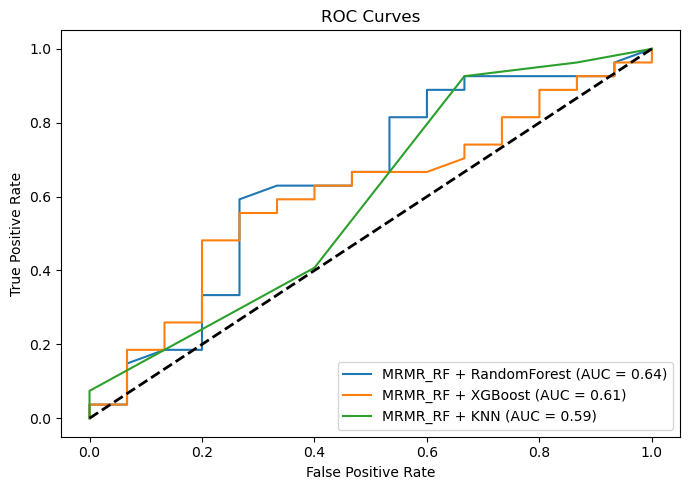

In [52]:
# Select the top 3 models based on the 'Test ROC-AUC' score 
top_models = results_df.nlargest(3, 'Test ROC-AUC')  

# ROC curves
plt.figure(figsize=(7, 5))
for index, model in top_models.iterrows():
    # Extract the classifier name and feature set used
    clf_name = model['Classifier']
    feature_set_name = model['Feature_Set']

    # Retrieve the predicted probabilities for the positive class
    y_pred_prob = model['y_pred_prob']  

    # Calculate the False Positive Rate (FPR), True Positive Rate (TPR), and thresholds for the ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # ROC Curve plot
    plt.plot(fpr, tpr, label=f"{feature_set_name} + {clf_name} (AUC = {roc_auc:.2f})")

# Diagonal reference line 
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Tabels, title, and legend 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


### Precision - recall curves

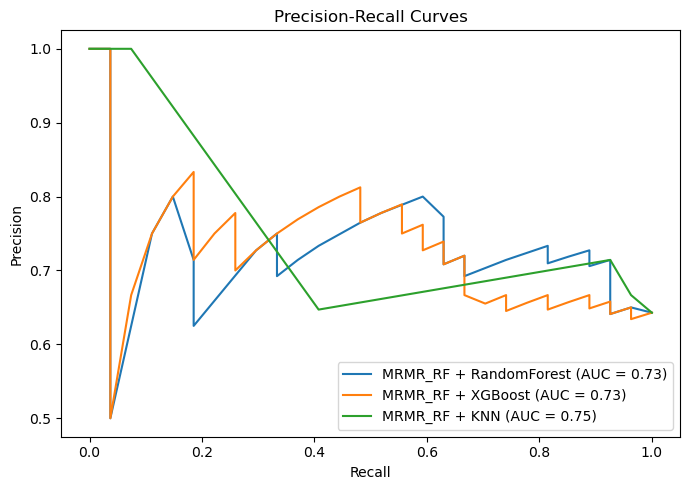

In [53]:
# Select the top 3 models based on 'Test ROC-AUC' to analyze their performance further
top_models = results_df.nlargest(3, 'Test ROC-AUC') 

# Precision-Recall curves

plt.figure(figsize=(7, 5))
for index, model in top_models.iterrows():
    # Extract the feature set name, classifier name, and predicted probabilities for the positive class
    feature_set = model['Feature_Set']
    clf_name = model['Classifier']

    # Retrieve the predicted probabilities for the positive class
    y_pred_prob = model['y_pred_prob']  

    # Calculate Precision and Recall values and the corresponding thresholds
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
    pr_auc = auc(recall, precision)

    # Plot the Precision-Recall curve 
    plt.plot(recall, precision, label=f"{feature_set} + {clf_name} (AUC = {pr_auc:.2f})")

# Configure the plot with labels, title, and legend
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


### Results heatmap

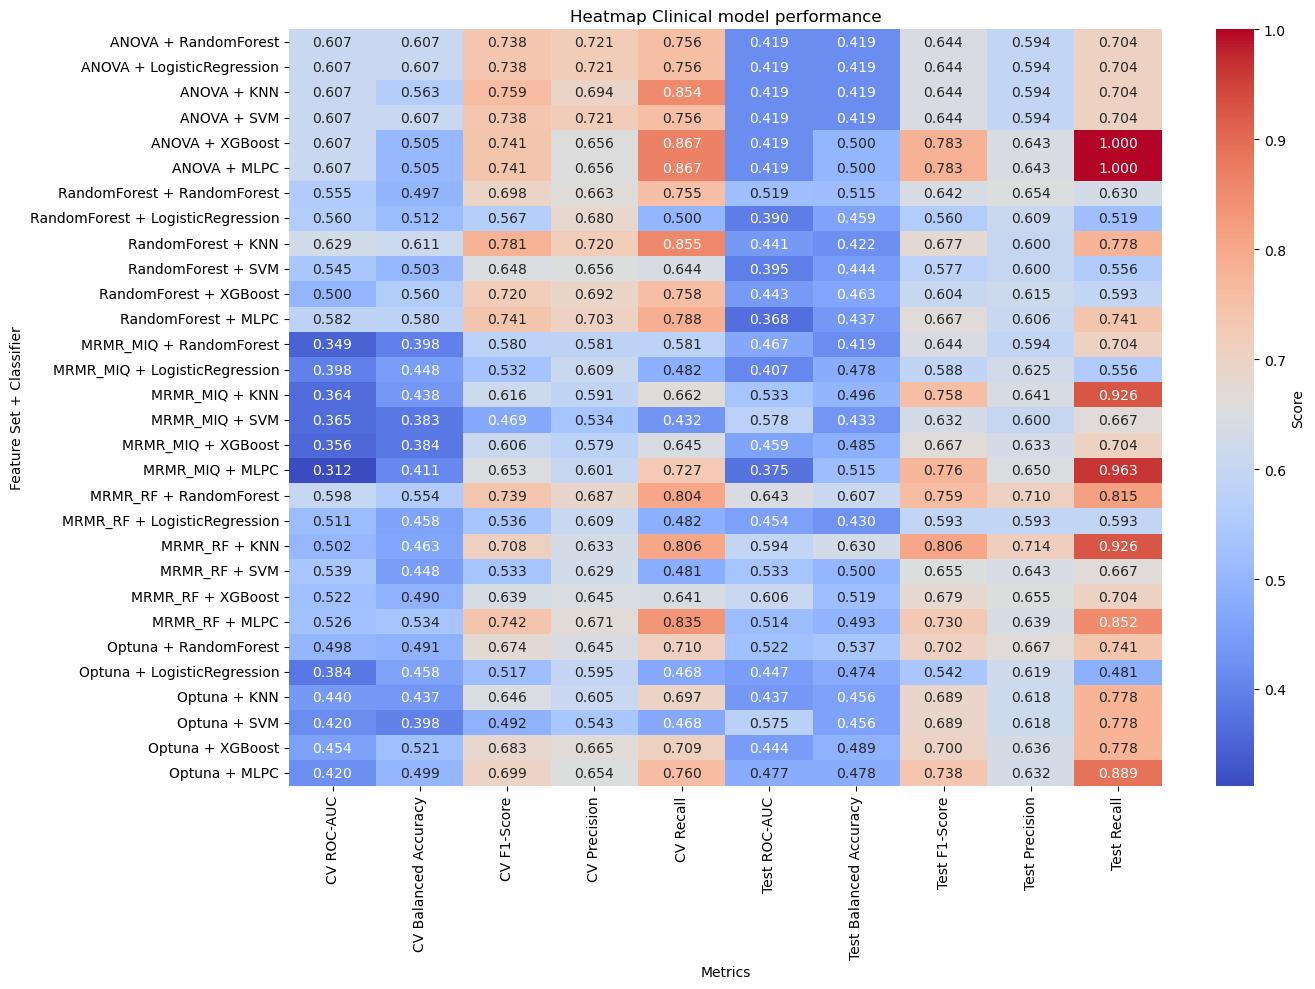

In [ ]:
# Key metrics to include in the heatmap
metrics = ['CV ROC-AUC', 'CV Balanced Accuracy', 'CV F1-Score', 'CV Precision', 'CV Recall', 
           'Test ROC-AUC','Test Balanced Accuracy', 'Test F1-Score','Test Precision', 'Test Recall']

# Create a new column that combines the feature set name and classifier name
results_df['Model'] = results_df['Feature_Set'] + ' + ' + results_df['Classifier']

# Filter the DataFrame to keep only the selected metrics and the 'Model' column
heatmap_data = results_df[metrics + ['Model']].set_index('Model')

# Create a heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".3f", cbar_kws={'label': 'Score'})
plt.title('Heatmap Clinical model performance')
plt.ylabel('Feature Set + Classifier')
plt.xlabel('Metrics')
plt.tight_layout()
plt.show()


### Confusion matrices

#### Standard threshold

Index(['Feature_Set', 'Classifier', 'Feature_Importances', 'y_pred_prob',
       'y_pred_test', 'CV ROC-AUC', 'CV ROC-AUC (std)', 'CV Balanced Accuracy',
       'CV Precision', 'CV Recall', 'CV F1-Score', 'Test Balanced Accuracy',
       'Test Precision', 'Test Recall', 'Test F1-Score', 'Test ROC-AUC'],
      dtype='object')


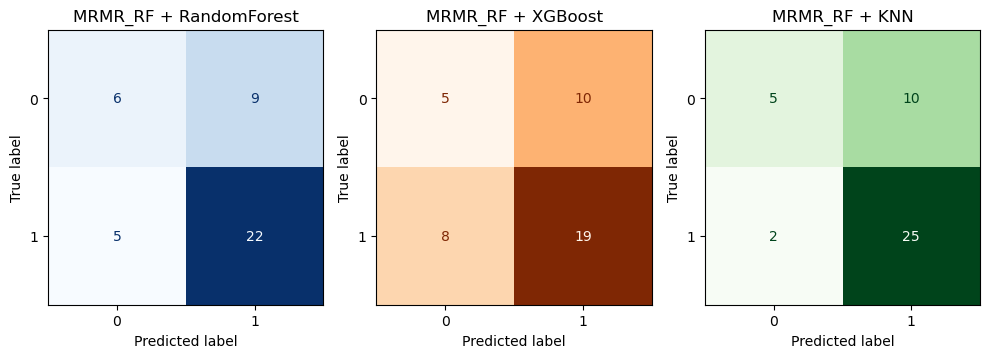

  Feature Selector    Classifier Balanced Accuracy F1 Score Precision Recall
0          MRMR_RF  RandomForest              0.61     0.76      0.71   0.81
1          MRMR_RF       XGBoost              0.52     0.68      0.66   0.70
2          MRMR_RF           KNN              0.63     0.81      0.71   0.93


In [9]:
# Load the results DataFrame from a previously saved file
with open('clinical_results_df.pkl', 'rb') as f:
    results_df = pickle.load(f)

# List to store metrics for each top model
metrics_data = []

# Select the top 3 models based on their test ROC-AUC score
top_models = results_df.nlargest(3, 'Test ROC-AUC')

# Figure with 3 subplots arranged in a single row
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

# Custom color maps for the confusion matrices
color_maps = ['Blues', 'Oranges', 'Greens']  

# Confusion matrices for the top models
for ax, (_, model), cmap in zip(axes, top_models.iterrows(), color_maps):
    # Extract the feature set name and classifier name
    feature_set = model['Feature_Set']
    clf_name = model['Classifier']
    y_pred_test = model['y_pred_test']

    # Compute the confusion matrix for the test set predictions
    cm = confusion_matrix(y_test, y_pred_test)
    
    # Visualize the confusion matrix with the assigned color map
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, cmap=cmap, colorbar=False)  
    
    # Set the title of the subplot with the feature set and classifier names
    ax.set_title(f"{feature_set} + {clf_name}")

    # Calculate additional performance metrics
    balanced_acc = balanced_accuracy_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test)
    precision = precision_score(y_test, y_pred_test)
    recall = recall_score(y_test, y_pred_test)
    
    # Store the metrics in the list for later visualization
    metrics_data.append({
        "Feature Selector": feature_set,
        "Classifier": clf_name,
        "Balanced Accuracy": f"{balanced_acc:.2f}",
        "F1 Score": f"{f1:.2f}",
        "Precision": f"{precision:.2f}",
        "Recall": f"{recall:.2f}"
    })


# Adjust the layout of the figure for better visualization
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()

# Convert the metrics data into a DataFrame for display
metrics_df = pd.DataFrame(metrics_data)
print(metrics_df)

#### Youden index CM

In [ ]:
# Load the results DataFrame from a previously saved file
with open('clinical_results_df.pkl', 'rb') as f:
    results_df = pickle.load(f)

# Initialize a list to store metrics for each top model
metrics_data = []

# Select the top 3 models based on their test ROC-AUC score
top_models = results_df.nlargest(3, 'Test ROC-AUC') 

# Create a figure with 3 subplots arranged in a single row
fig, axes = plt.subplots(1, 3, figsize=(11, 5))

# Define custom color maps for the confusion matrices
color_maps = ['Blues', 'Oranges', 'Greens']  

# Generate confusion matrices for the top models
thresholds = np.arange(0.0, 1.1, 0.01)

# Generar las matrices de confusión para los mejores modelos
for ax, (_, model), cmap in zip(axes, top_models.iterrows(), color_maps):
    # Extract the feature set name and classifier name
    feature_set = model['Feature_Set']
    clf_name = model['Classifier']
    y_pred_prob = model['y_pred_prob']  
    
    # Calculate the Youden Index for different thresholds
    fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_prob)
    youden_index = tpr - fpr  # Youden Index = Sensitivity + Specificity - 1
    best_threshold = thresholds_roc[np.argmax(youden_index)]  # Umbral óptimo según el Youden Index
    y_pred_adjusted = (y_pred_prob >= best_threshold).astype(int)  # Ajustar las predicciones

    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, y_pred_adjusted)
    
    # Visualize the confusion matrix with the corresponding color map
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, cmap=cmap, colorbar=False)  

    # Set the subplot title
    ax.set_title(f"{feature_set} + {clf_name} (Threshold: {best_threshold:.2f})")

    # Calculate metrics
    balanced_acc = balanced_accuracy_score(y_test, y_pred_adjusted)
    f1 = f1_score(y_test, y_pred_adjusted)
    precision = precision_score(y_test, y_pred_adjusted)
    recall = recall_score(y_test, y_pred_adjusted)
    
    # Store the results in the list
    metrics_data.append({
        "Feature Selector": feature_set,
        "Classifier": clf_name,
        "Balanced Accuracy": f"{balanced_acc:.2f}",
        "F1 Score": f"{f1:.2f}",
        "Precision": f"{precision:.2f}",
        "Recall": f"{recall:.2f}"
    })


# Adjust the layout of the figure to prevent title overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.show()

#### F1-score CM

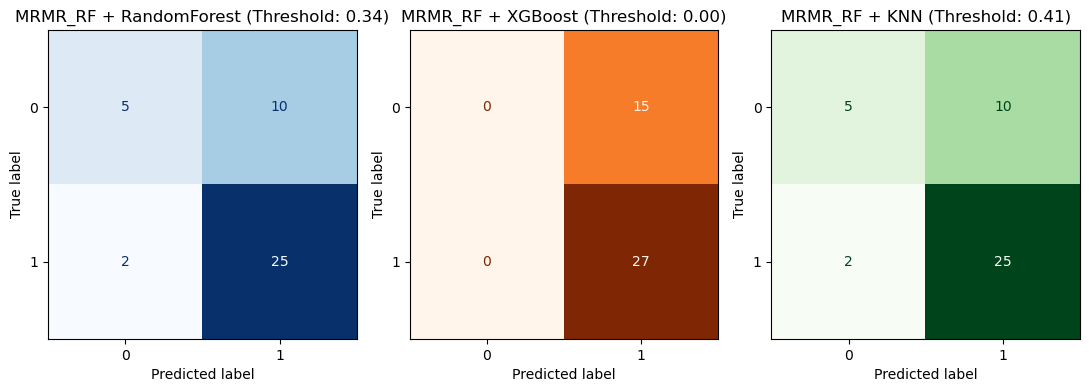

  Feature Selector    Classifier Balanced Accuracy F1 Score Precision Recall
0          MRMR_RF  RandomForest              0.63     0.81      0.71   0.93
1          MRMR_RF       XGBoost              0.50     0.78      0.64   1.00
2          MRMR_RF           KNN              0.63     0.81      0.71   0.93


In [14]:
# Load the results DataFrame from a pickle file
with open('clinical_results_df.pkl', 'rb') as f:
    results_df = pickle.load(f)

metrics_data = []

# Select the best models
top_models = results_df.nlargest(3, 'Test ROC-AUC')  

# Create a figure with 3 subplots in a single row
fig, axes = plt.subplots(1, 3, figsize=(11, 5))

# Custom color schemes for each confusion matrix
color_maps = ['Blues', 'Oranges', 'Greens'] 

# Define the threshold range
thresholds = np.arange(0.0, 1.1, 0.01)

# Generate confusion matrices for the top models
for ax, (_, model), cmap in zip(axes, top_models.iterrows(), color_maps):
    # Extract the model name and predictions
    feature_set = model['Feature_Set']
    clf_name = model['Classifier']
    y_pred_prob = model['y_pred_prob']  
    
    # Calculate the best threshold based on the F1-score
    f1_scores = [f1_score(y_test, (y_pred_prob >= t).astype(int)) for t in thresholds]
    best_threshold = thresholds[np.argmax(f1_scores)]  # Umbral óptimo basado en el mejor F1 score
    y_pred_adjusted = (y_pred_prob >= best_threshold).astype(int)  # Ajustar las predicciones

    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, y_pred_adjusted)
    
    # Visualize the confusion matrix with the corresponding color map
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, cmap=cmap, colorbar=False)  # Asignar un cmap diferente por modelo
    
    # Set the subplot title
    ax.set_title(f"{feature_set} + {clf_name} (Threshold: {best_threshold:.2f})")

    # Calculate metrics
    balanced_acc = balanced_accuracy_score(y_test, y_pred_adjusted)
    f1 = f1_score(y_test, y_pred_adjusted)
    precision = precision_score(y_test, y_pred_adjusted)
    recall = recall_score(y_test, y_pred_adjusted)
    
    # Store the results in the list
    metrics_data.append({
        "Feature Selector": feature_set,
        "Classifier": clf_name,
        "Balanced Accuracy": f"{balanced_acc:.2f}",
        "F1 Score": f"{f1:.2f}",
        "Precision": f"{precision:.2f}",
        "Recall": f"{recall:.2f}"
    })

# Adjust the layout of the figure to prevent title overlap
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()

# Convert the metrics data into a DataFrame 
metrics_df = pd.DataFrame(metrics_data)

# Mostrar la tabla de resultados
print(metrics_df)

### Clinical feature importances

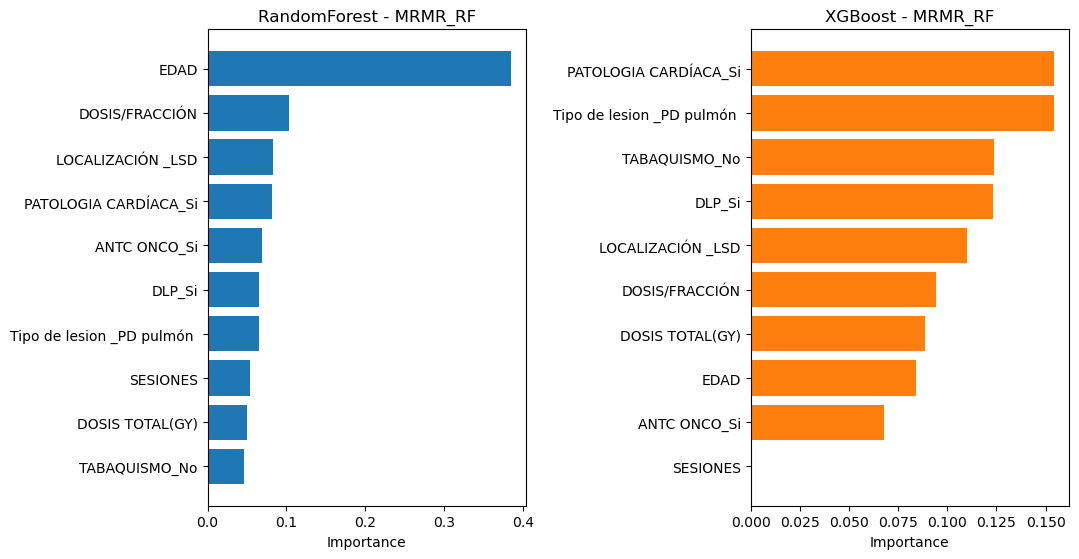

In [ ]:
# Seleccionar los 3 mejores modelos
top_models = results_df.nlargest(2, 'Test ROC-AUC')  # Selecciona los 3 mejores modelos

# Crear figura con 3 subplots en una sola fila
fig, axes = plt.subplots(1, 2, figsize=(11, 6))

# Esquemas de colores fijos para cada gráfico
colors = ['#1f77b4', '#ff7f0e']  # Colores sólidos (azul, naranja, verde)

# Generar los gráficos de feature importances para los mejores modelos
for ax, (_, model), color in zip(axes, top_models.iterrows(), colors):
    # Extraer el nombre del modelo y las importancias
    clf_name = model['Classifier']
    feature_importances = model['Feature_Importances']  # Asegúrate de que esté en 'results_df'

    # Ordenar las características por importancia
    sorted_features = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)
    features, importances = zip(*sorted_features)

    # Plotear con un color sólido
    ax.barh(features, importances, color=color)
    
    # Configurar el título del subplot
    ax.set_title(f"{clf_name} - {model['Feature_Set']}")
    ax.set_xlabel('Importance')
    ax.invert_yaxis()  # Invertir el eje Y para que la característica más importante esté arriba

# Ajustar el layout de la figura
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajustar para no solapar el título
plt.show()


# All features models
## Feature selection

In [135]:
# Initialize the StratifiedKFold cross-validation with 5 splits
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Generate the splits (indices) for the train data
splits = list(kf.split(x_train, y_train))

# Dictionary storing feature selection methods and results
allVariables_feature_sets = {
        'Lasso': lasso_feature_selection(x_train, y_train),
        'ANOVA': anova_feature_selection(x_train, y_train),
        'RandomForest': rf_feature_selection(x_train, y_train),
        'MRMR_MIQ': mrmr_feature_selection(x_train, y_train, method="MIQ"),
        'MRMR_RF': mrmr_feature_selection(x_train, y_train, method="RFCQ"),    
        'Optuna': optuna_feature_selection(x_train, y_train, splits)
    }

# Save the results in a pickle file
#with open('allVariables_feature_sets.pkl', 'wb') as f:
#    pickle.dump(allVariables_feature_sets, f)

c:\Users\pcbox\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.112e-03, tolerance: 1.741e-03
  model = cd_fast.enet_coordinate_descent(
c:\Users\pcbox\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.412e-03, tolerance: 1.741e-03
  model = cd_fast.enet_coordinate_descent(
c:\Users\pcbox\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.832e-03, toleranc

### Presence - absence table

In [142]:
# Get all unique features
all_features = list(set().union(*allVariables_feature_sets.values()))  # Convert the set to a list

# Create the presence-absence table
presence_absence_table = pd.DataFrame(index=all_features, columns=allVariables_feature_sets.keys())
for method, features in allVariables_feature_sets.items():
    presence_absence_table[method] = presence_absence_table.index.isin(features).astype(int)

# Add a "total" column to count the number of methods selecting each feature
presence_absence_table['Total_Selected'] = presence_absence_table.sum(axis=1)

# Reorder the table based on the "Total_Selected" column in descending order
presence_absence_table = presence_absence_table.sort_values(by='Total_Selected', ascending=False)

# Filter features selected by the majority of methods
majority_threshold = len(allVariables_feature_sets) // 2  # Majority: more than half the methods
selected_by_majority = presence_absence_table[presence_absence_table['Total_Selected'] >= majority_threshold]

# Display results
display(presence_absence_table)
print("\nFeatures selected by the majority of methods:\n", selected_by_majority.index)
presence_absence_table.to_excel('PresenceAbsence_allVariables.xlsx', index=True)


Lasso  ANOVA  \
lbp-3D-k_gldm_SmallDependenceEmphasis                   0      0   
wavelet-HHL_gldm_DependenceVariance                     0      0   
lbp-3D-m2_glrlm_LongRunLowGrayLevelEmphasis             0      0   
wavelet-LHL_glcm_JointAverage                           0      0   
gradient_glcm_DifferenceVariance                        0      0   
...                                                   ...    ...   
wavelet-LLL_gldm_LargeDependenceLowGrayLevelEmp...      0      0   
wavelet-LLH_glcm_DifferenceVariance                     0      0   
square_gldm_HighGrayLevelEmphasis                       0      0   
gradient_ngtdm_Strength                                 0      0   
wavelet-LLH_glszm_LargeAreaEmphasis                     0      0   

                                                    RandomForest  MRMR_MIQ  \
lbp-3D-k_gldm_SmallDependenceEmphasis                          1         0   
wavelet-HHL_gldm_DependenceVariance                            1         0   
lbp-3D-m2_glrlm_LongRunLowGrayLevelEmphasis                    0         1   
wavelet-LHL_glcm_JointAverage                                  0         1   
gradient_glcm_DifferenceVariance                               1         0   
...                                                          ...       ...   
wavelet-LLL_gldm_LargeDependenceLowGrayLevelEmp...             0         0   
wavelet-LLH_glcm_DifferenceVariance                            0         0   
square_gldm_HighGrayLevelEmphasis                              0         0   
gradient_ngtdm_Strength                                        0         0   
wavelet-LLH_glszm_LargeAreaEmphasis                            0         0   

                                                    MRMR_RF  Optuna  \
lbp-3D-k_gldm_SmallDependenceEmphasis                     1       1   
wavelet-HHL_gldm_DependenceVariance                       1       1   
lbp-3D-m2_glrlm_LongRunLowGrayLevelEmphasis               0       1   
wavelet-LHL_glcm_JointAverage                             0       1   
gradient_glcm_DifferenceVariance                          0       1   
...                                                     ...     ...   
wavelet-LLL_gldm_LargeDependenceLowGrayLevelEmp...        0       1   
wavelet-LLH_glcm_DifferenceVariance                       0       1   
square_gldm_HighGrayLevelEmphasis                         0       1   
gradient_ngtdm_Strength                                   0       1   
wavelet-LLH_glszm_LargeAreaEmphasis                       0       1   

                                                    Total_Selected  
lbp-3D-k_gldm_SmallDependenceEmphasis                            3  
wavelet-HHL_gldm_DependenceVariance                              3  
lbp-3D-m2_glrlm_LongRunLowGrayLevelEmphasis                      2  
wavelet-LHL_glcm_JointAverage                                    2  
gradient_glcm_DifferenceVariance                                 2  
...                                                            ...  
wavelet-LLL_gldm_LargeDependenceLowGrayLevelEmp...               1  
wavelet-LLH_glcm_DifferenceVariance                              1  
square_gldm_HighGrayLevelEmphasis                                1  
gradient_ngtdm_Strength                                          1  
wavelet-LLH_glszm_LargeAreaEmphasis                              1  

[768 rows x 7 columns]


Features selected by the majority of methods:
 Index(['lbp-3D-k_gldm_SmallDependenceEmphasis', 'wavelet-HHL_gldm_DependenceVariance'], dtype='object')


## Training and testing models

In [136]:
# Dictionary of classifiers
clfs = {
    'RandomForest': RandomForestClassifier(random_state=2024, class_weight='balanced'),
    'LogisticRegression': LogisticRegression(random_state=2024, max_iter=1000, class_weight='balanced'),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True, random_state=2024, class_weight='balanced'),
    'XGBoost': xgb.XGBClassifier(objective="binary:logistic", random_state=2024),
    'MLPC': MLPClassifier(random_state=2024)
}

# Scoring metrics
scoring = {
    'roc_auc': 'roc_auc',
    'balanced_accuracy': make_scorer(balanced_accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

# Results container
results = []

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2024)

# Iterate over each feature set
for feature_set_name, selected_features in allVariables_feature_sets.items():
    if len(selected_features) != 0:
         # Extract the selected features for training and testing
         X_train = x_train[selected_features]
         X_test = x_test[selected_features]
         
         # Iterate over each classifier
         for clf_name, clf in clfs.items():
            # Cross-validation results
             cv_results = cross_validate(
                clf, X_train, y_train, scoring=scoring, cv=cv, return_train_score=True
                )
        
            # Train the model
             clf.fit(X_train, y_train)
        
            # Make predictions on the test set
             y_pred_prob = clf.predict_proba(X_test)[:, 1]
             y_pred_test = clf.predict(X_test)
            
            # Get feature importances
             if hasattr(clf, "feature_importances_"):
                feature_importances = clf.feature_importances_
             elif hasattr(clf, "coef_"):
                feature_importances = np.abs(clf.coef_)[0]
             
            # Store results
             results.append({
                'Feature_Set': feature_set_name,
                'Classifier': clf_name,
                'Feature_Importances': dict(zip(selected_features, feature_importances)),
                'y_pred_prob': y_pred_prob,
                'y_pred_test': y_pred_test,
                'CV ROC-AUC': cv_results['test_roc_auc'].mean(),
                'CV ROC-AUC (std)': cv_results['test_roc_auc'].std(),
                'CV Balanced Accuracy': cv_results['test_balanced_accuracy'].mean(),
                'CV Precision': cv_results['test_precision'].mean(),
                'CV Recall': cv_results['test_recall'].mean(),
                'CV F1-Score': cv_results['test_f1'].mean(),
                'Test Balanced Accuracy': balanced_accuracy_score(y_test, y_pred_test),
                'Test Precision': precision_score(y_test, y_pred_test),
                'Test Recall': recall_score(y_test, y_pred_test),
                'Test F1-Score': f1_score(y_test, y_pred_test),
                'Test ROC-AUC': roc_auc_score(y_test, y_pred_prob),
                })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Save the results to a file
with open('allVariables_results_df.pkl', 'wb') as f:
     pickle.dump(results_df, f)

c:\Users\pcbox\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\pcbox\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\pcbox\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\pcbox\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\pcbox\anaconda3\Lib\site-packages\sklearn\neural_network\_multi

### Results Table

In [137]:
# Sort the table by Test ROC-AUC
sorted_results_df = results_df.sort_values(by='Test ROC-AUC', ascending=False)

# Select important columns for display
columns_to_display = [
    'Feature_Set', 'Classifier', 'CV ROC-AUC', 'CV ROC-AUC (std)', 'CV Balanced Accuracy', 'CV F1-Score', 'CV Precision',
     'CV Recall', 'Test ROC-AUC', 'Test Balanced Accuracy', 'Test F1-Score', 'Test Precision', 
    'Test Recall'
]

# Filter and display
results_table = sorted_results_df[columns_to_display].round(3)

# Display the table (top 10 rows)
display(results_table.head(10))

# Save the table to an Excel file
results_table.to_excel('clinicalANDradiomic_model_results.xlsx', index=False)


Feature_Set    Classifier  CV ROC-AUC  CV ROC-AUC (std)  \
12    MRMR_MIQ  RandomForest       0.654             0.084   
24      Optuna  RandomForest       0.530             0.072   
3        ANOVA           SVM       0.583             0.176   
16    MRMR_MIQ       XGBoost       0.643             0.070   
4        ANOVA       XGBoost       0.630             0.105   
21     MRMR_RF           SVM       0.637             0.097   
18     MRMR_RF  RandomForest       0.717             0.052   
26      Optuna           KNN       0.463             0.141   
5        ANOVA          MLPC       0.541             0.171   
29      Optuna          MLPC       0.521             0.178   

    CV Balanced Accuracy  CV F1-Score  CV Precision  CV Recall  Test ROC-AUC  \
12                 0.625        0.785         0.727      0.855         0.614   
24                 0.559        0.765         0.684      0.871         0.581   
3                  0.489        0.589         0.618      0.582         0.568   
16                 0.590        0.746         0.709      0.790         0.560   
4                  0.619        0.774         0.735      0.823         0.551   
21                 0.613        0.703         0.735      0.678         0.548   
18                 0.650        0.811         0.739      0.904         0.546   
26                 0.435        0.654         0.614      0.708         0.546   
5                  0.581        0.763         0.694      0.858         0.543   
29                 0.553        0.707         0.682      0.738         0.526   

    Test Balanced Accuracy  Test F1-Score  Test Precision  Test Recall  
12                   0.567          0.679           0.692        0.667  
24                   0.567          0.679           0.692        0.667  
3                    0.574          0.578           0.722        0.481  
16                   0.567          0.679           0.692        0.667  
4                    0.567          0.679           0.692        0.667  
21                   0.478          0.588           0.625        0.556  
18                   0.567          0.679           0.692        0.667  
26                   0.593          0.767           0.697        0.852  
5                    0.541          0.733           0.667        0.815  
29                   0.481          0.630           0.630        0.630

### ROC curves

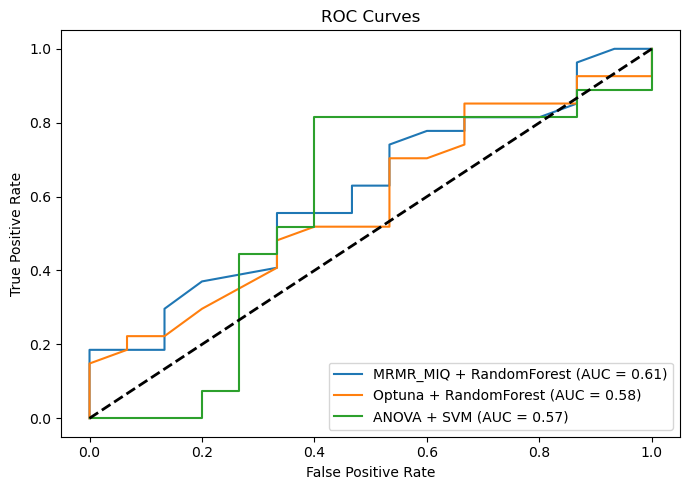

In [138]:
# Select the top models based on Test ROC-AUC
top_models = results_df.nlargest(3, 'Test ROC-AUC')  # Selecciona los 3 mejores modelos (ajusta según prefieras)

# Set up the figure for ROC curves
plt.figure(figsize=(7, 5))

# Generate ROC curves for the top models
for index, model in top_models.iterrows():
    # Extract the classifier name and predicted probabilities
    clf_name = model['Classifier']
    feature_set_name = model['Feature_Set']
    y_pred_prob = model['y_pred_prob']  

    # Calculate ROC points
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f"{feature_set_name} + {clf_name} (AUC = {roc_auc:.2f})")

# Add diagonal reference line and plot labels
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

### Precision - recall curves

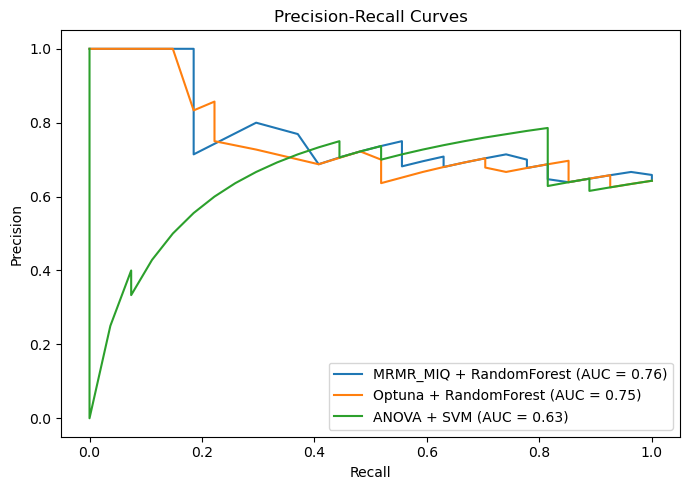

In [139]:
# Select the top models based on Test ROC-AU
top_models = results_df.nlargest(3, 'Test ROC-AUC') 

# Set up the figure 
plt.figure(figsize=(7, 5))

# Generate Precision-recall curves for the top models
for index, model in top_models.iterrows():
    # Extract the classifier name and predicted probabilities
    feature_set = model['Feature_Set']
    clf_name = model['Classifier']
    y_pred_prob = model['y_pred_prob']  

    # Calculate Precision-Recall points
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
    pr_auc = auc(recall, precision)

    # Display precision-recall curve
    plt.plot(recall, precision, label=f"{feature_set} + {clf_name} (AUC = {pr_auc:.2f})")

# Add diagonal reference line and labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


### Results Heatmap

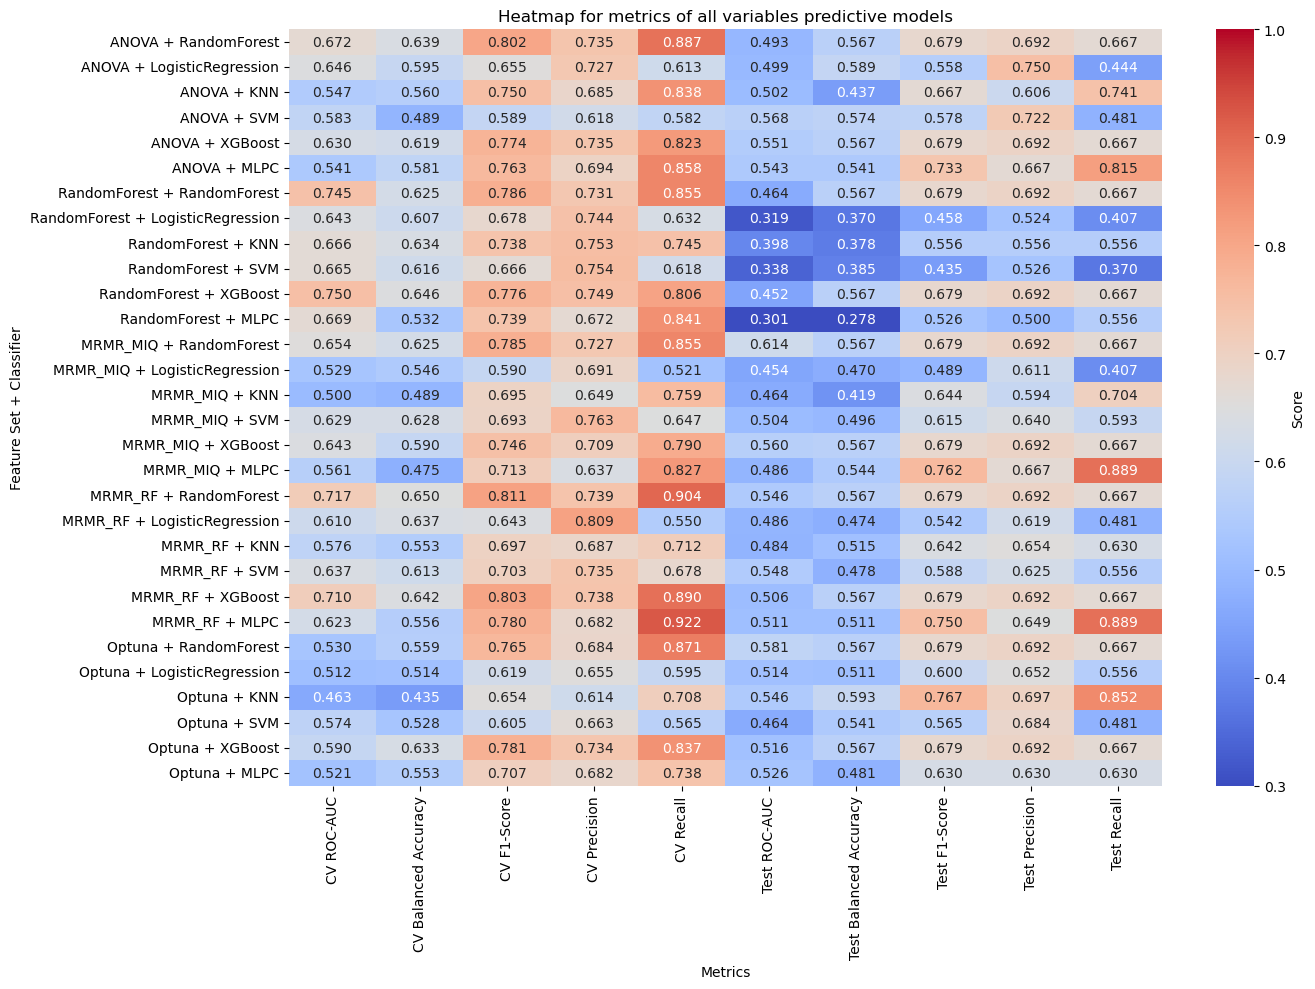

In [143]:
# Select the key metrics for the heatmap
metrics = ['CV ROC-AUC', 'CV Balanced Accuracy', 'CV F1-Score', 'CV Precision', 'CV Recall', 
           'Test ROC-AUC','Test Balanced Accuracy', 'Test F1-Score','Test Precision', 'Test Recall']

# Create a combined column with 'Feature_Set' and 'Classifier'
results_df['Model'] = results_df['Feature_Set'] + ' + ' + results_df['Classifier']

# Filter the metrics and set the new 'Model' column as the index
heatmap_data = results_df[metrics + ['Model']].set_index('Model')

# Generate the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".3f", cbar_kws={'label': 'Score'}, vmin=0.3, vmax=1)
plt.title('Heatmap for metrics of all variables predictive models')
plt.ylabel('Feature Set + Classifier')
plt.xlabel('Metrics')
plt.tight_layout()
plt.show()

### Confusion Matrices

#### Standard CM

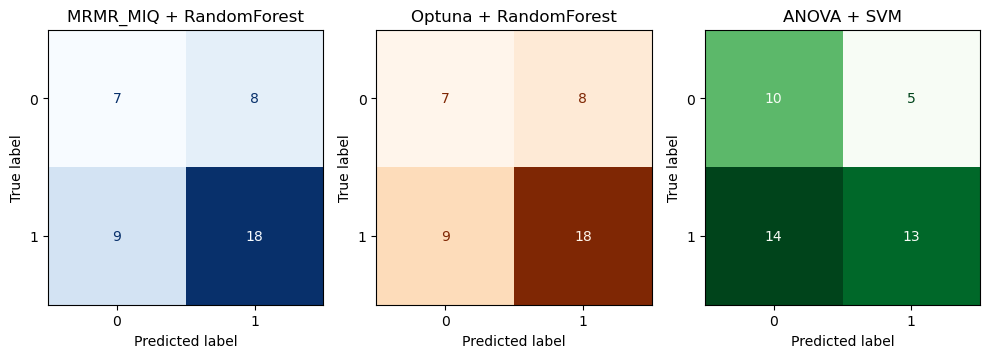

Feature Selector    Classifier Balanced Accuracy F1 Score Precision Recall
0         MRMR_MIQ  RandomForest              0.57     0.68      0.69   0.67
1           Optuna  RandomForest              0.57     0.68      0.69   0.67
2            ANOVA           SVM              0.57     0.58      0.72   0.48

In [76]:
# Load the results DataFrame from a previously saved file
with open('allVariables_results_df.pkl', 'rb') as f:
    results_df = pickle.load(f)

# Initialize a list to store metrics for each top model
metrics_data = []

# Select the top 3 models based on their test ROC-AUC score
top_models = results_df.nlargest(3, 'Test ROC-AUC')  # Selecciona los 3 mejores modelos

# Create a figure with 3 subplots arranged in a single row
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

# Define custom color maps for the confusion matrices
color_maps = ['Blues', 'Oranges', 'Greens']  # Colores distintos para cada una

# Generate confusion matrices for the top models
for ax, (_, model), cmap in zip(axes, top_models.iterrows(), color_maps):
    # Extract the feature set name and classifier name
    feature_set = model['Feature_Set']
    clf_name = model['Classifier']
    y_pred_test = model['y_pred_test']  

    # Compute the confusion matrix for the test set predictions
    cm = confusion_matrix(y_test, y_pred_test)
    
    # Visualize the confusion matrix with the assigned color map
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, cmap=cmap, colorbar=False)  # Asignar un cmap diferente por modelo
    
    # Set the title of the subplot with the feature set and classifier names
    ax.set_title(f"{feature_set} + {clf_name}")

    # Calculate additional performance metrics
    balanced_acc = balanced_accuracy_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test)
    precision = precision_score(y_test, y_pred_test)
    recall = recall_score(y_test, y_pred_test)
    
    # Store the metrics in the list for later visualization
    metrics_data.append({
        "Feature Selector": feature_set,
        "Classifier": clf_name,
        "Balanced Accuracy": f"{balanced_acc:.2f}",
        "F1 Score": f"{f1:.2f}",
        "Precision": f"{precision:.2f}",
        "Recall": f"{recall:.2f}"
    })


# Adjust the layout of the figure for better visualization
plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.show()

# Convert the metrics data into a DataFrame for display
metrics_df = pd.DataFrame(metrics_data)
display(metrics_df)

#### Youden CM

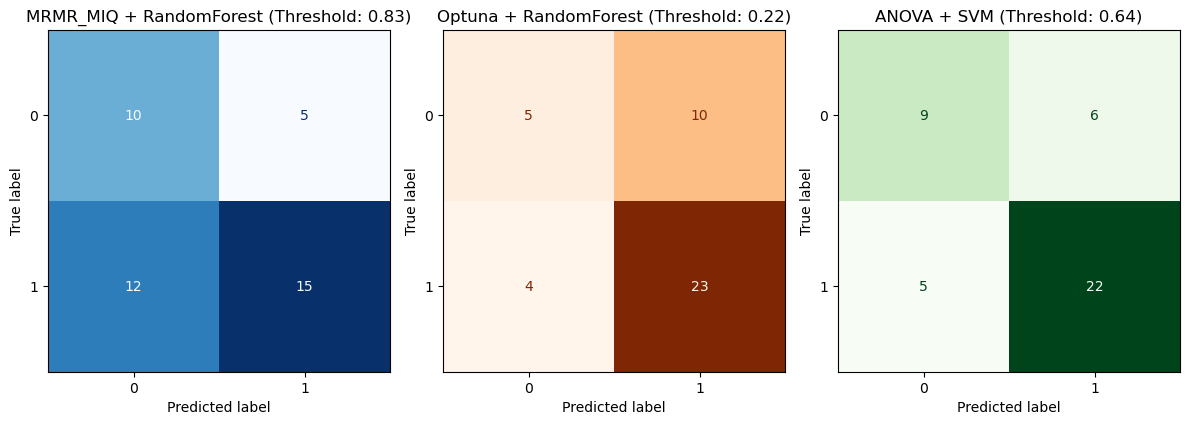

Feature Selector    Classifier Balanced Accuracy F1 Score Precision Recall
0         MRMR_MIQ  RandomForest              0.61     0.64      0.75   0.56
1           Optuna  RandomForest              0.59     0.77      0.70   0.85
2            ANOVA           SVM              0.71     0.80      0.79   0.81

In [18]:
# Load the results DataFrame from a previously saved file
with open('allVariables_results_df.pkl', 'rb') as f:
    results_df = pickle.load(f)

# Initialize a list to store metrics for each top model
metrics_data = []

# Select the top 3 models based on their test ROC-AUC score
top_models = results_df.nlargest(3, 'Test ROC-AUC')  

# Create a figure with 3 subplots arranged in a single row
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

# Define custom color maps for the confusion matrices
color_maps = ['Blues', 'Oranges', 'Greens']  

# Define the threshold range
thresholds = np.arange(0.0, 1.1, 0.01)

# Generate confusion matrices for the top models
for ax, (_, model), cmap in zip(axes, top_models.iterrows(), color_maps):
    # Extract the model name and predictions
    feature_set = model['Feature_Set']
    clf_name = model['Classifier']
    y_pred_prob = model['y_pred_prob']  
    
    # Calculate the Youden Index for different thresholds
    fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_prob)
    youden_index = tpr - fpr  # Youden Index = Sensitivity + Specificity - 1
    best_threshold = thresholds_roc[np.argmax(youden_index)]  
    y_pred_adjusted = (y_pred_prob >= best_threshold).astype(int)  

    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, y_pred_adjusted)
    
    # Visualize the confusion matrix with the corresponding color map
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, cmap=cmap, colorbar=False)  # Asignar un cmap diferente por modelo
    
    # Set the subplot title
    ax.set_title(f"{feature_set} + {clf_name} (Threshold: {best_threshold:.2f})")

    # Calculate metrics
    balanced_acc = balanced_accuracy_score(y_test, y_pred_adjusted)
    f1 = f1_score(y_test, y_pred_adjusted)
    precision = precision_score(y_test, y_pred_adjusted)
    recall = recall_score(y_test, y_pred_adjusted)
    
    # Store the results in the list
    metrics_data.append({
        "Feature Selector": feature_set,
        "Classifier": clf_name,
        "Balanced Accuracy": f"{balanced_acc:.2f}",
        "F1 Score": f"{f1:.2f}",
        "Precision": f"{precision:.2f}",
        "Recall": f"{recall:.2f}"
    })

# Adjust the layout of the figure to prevent title overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.show()

# Convert the metrics data into a DataFrame for further analysis or export
metrics_df = pd.DataFrame(metrics_data)
display(metrics_df)

#### F1 score CM

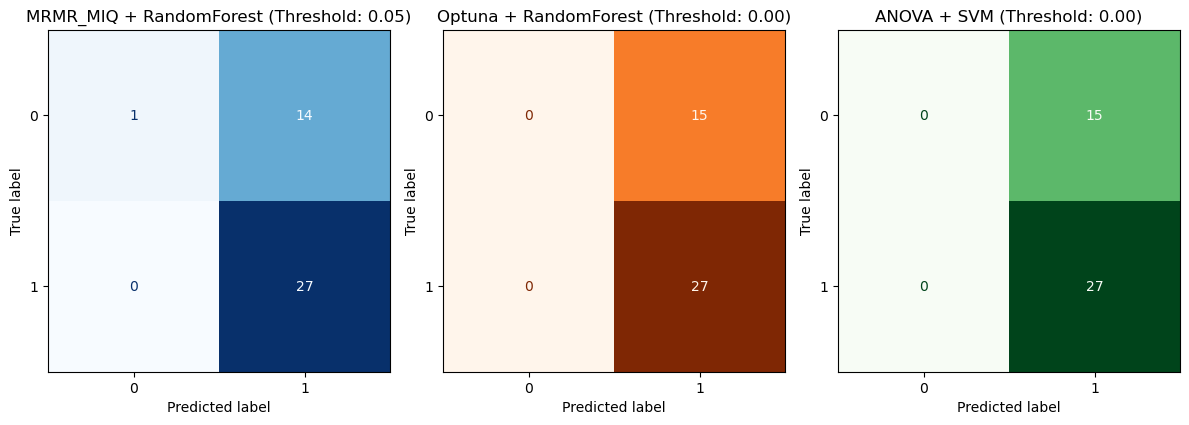

Feature Selector    Classifier Balanced Accuracy F1 Score Precision Recall
0         MRMR_MIQ  RandomForest              0.53     0.79      0.66   1.00
1           Optuna  RandomForest              0.50     0.78      0.64   1.00
2            ANOVA           SVM              0.50     0.78      0.64   1.00

In [17]:
with open('allVariables_results_df.pkl', 'rb') as f:
    results_df = pickle.load(f)

metrics_data = []

# Seleccionar los mejores modelos (por ejemplo, los 3 mejores modelos basados en ROC-AUC)
top_models = results_df.nlargest(3, 'Test ROC-AUC')  # Selecciona los 3 mejores modelos

# Crear figura con 3 subplots en una sola fila
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

# Esquemas de colores personalizados para cada matriz
color_maps = ['Blues', 'Oranges', 'Greens']  # Colores distintos para cada una

# Definir el rango de umbrales
thresholds = np.arange(0.0, 1.1, 0.01)

# Generar las matrices de confusión para los mejores modelos
for ax, (_, model), cmap in zip(axes, top_models.iterrows(), color_maps):
    # Extraer el nombre del modelo y las predicciones
    feature_set = model['Feature_Set']
    clf_name = model['Classifier']
    y_pred_prob = model['y_pred_prob']  # Asegúrate de que esto esté en 'results_df'
    
    # Calcular el mejor umbral basado en el F1-score
    f1_scores = [f1_score(y_test, (y_pred_prob >= t).astype(int)) for t in thresholds]
    best_threshold = thresholds[np.argmax(f1_scores)]  # Umbral óptimo basado en el mejor F1 score
    y_pred_adjusted = (y_pred_prob >= best_threshold).astype(int)  # Ajustar las predicciones

    # Calcular la matriz de confusión
    cm = confusion_matrix(y_test, y_pred_adjusted)
    
    # Visualizar la matriz de confusión con el esquema de colores correspondiente
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, cmap=cmap, colorbar=False)  # Asignar un cmap diferente por modelo
    
    # Configurar el título del subplot
    ax.set_title(f"{feature_set} + {clf_name} (Threshold: {best_threshold:.2f})")

        # Calcular métricas
    balanced_acc = balanced_accuracy_score(y_test, y_pred_adjusted)
    f1 = f1_score(y_test, y_pred_adjusted)
    precision = precision_score(y_test, y_pred_adjusted)
    recall = recall_score(y_test, y_pred_adjusted)
    
    # Almacenar los resultados en la lista
    metrics_data.append({
        "Feature Selector": feature_set,
        "Classifier": clf_name,
        "Balanced Accuracy": f"{balanced_acc:.2f}",
        "F1 Score": f"{f1:.2f}",
        "Precision": f"{precision:.2f}",
        "Recall": f"{recall:.2f}"
    })

# Ajustar el layout de la figura
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajustar para no solapar el título
plt.show()

metrics_df = pd.DataFrame(metrics_data)

# Mostrar la tabla de resultados
display(metrics_df)


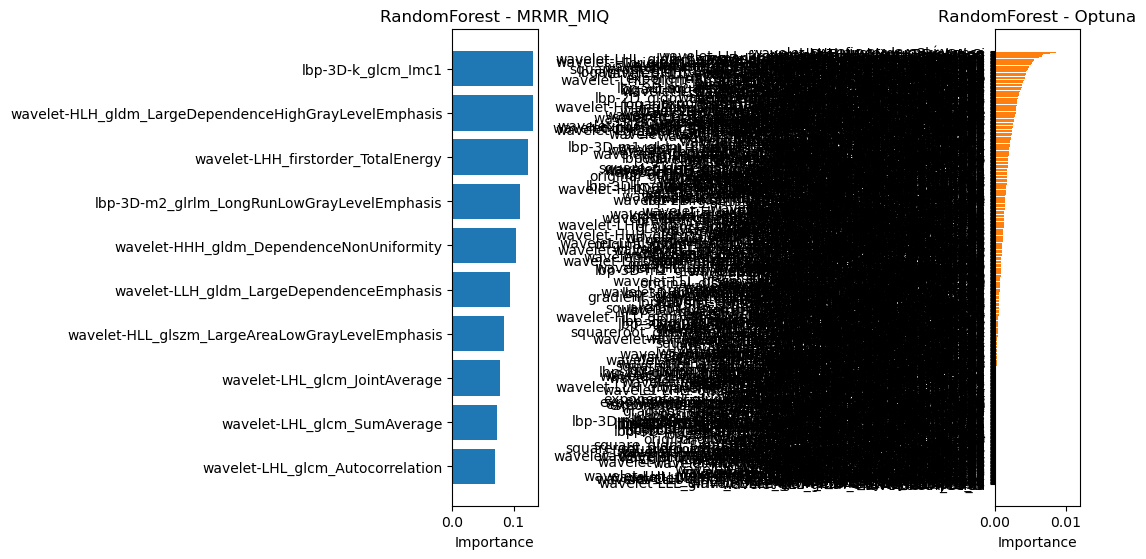

In [148]:
# Seleccionar los 3 mejores modelos
top_models = results_df.nlargest(2, 'Test ROC-AUC')  # Selecciona los 3 mejores modelos

# Crear figura con 3 subplots en una sola fila
fig, axes = plt.subplots(1, 2, figsize=(11, 6))

# Esquemas de colores fijos para cada gráfico
colors = ['#1f77b4', '#ff7f0e']  # Colores sólidos (azul, naranja, verde)

# Generar los gráficos de feature importances para los mejores modelos
for ax, (_, model), color in zip(axes, top_models.iterrows(), colors):
    # Extraer el nombre del modelo y las importancias
    clf_name = model['Classifier']
    feature_importances = model['Feature_Importances']  # Asegúrate de que esté en 'results_df'

    # Ordenar las características por importancia
    sorted_features = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)
    features, importances = zip(*sorted_features)

    # Plotear con un color sólido
    ax.barh(features, importances, color=color)
    
    # Configurar el título del subplot
    ax.set_title(f"{clf_name} - {model['Feature_Set']}")
    ax.set_xlabel('Importance')
    ax.invert_yaxis()  # Invertir el eje Y para que la característica más importante esté arriba

# Ajustar el layout de la figura
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajustar para no solapar el título
plt.show()

# Balanced clinical and radiomic data models 
## Radiomic feature selection

In [15]:
# Initialize Stratified K-Fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
splits = list(kf.split(x_train_radiomic, y_train))

# Dictionary with feature sets from different selection methods
radiomic_feature_sets = {
        'Lasso': lasso_feature_selection(x_train_radiomic, y_train),
        'ANOVA': anova_feature_selection(x_train_radiomic, y_train, top_n=5),
        'RandomForest': rf_feature_selection(x_train_radiomic, y_train, top_n=5),
        'MRMR_MIQ': mrmr_feature_selection(x_train_radiomic, y_train, method="MIQ", top_n=5),
        'MRMR_RF': mrmr_feature_selection(x_train_radiomic, y_train, method="RFCQ", top_n=5),    
        'Optuna': optuna_feature_selection(x_train_radiomic, y_train, splits)
    }

# Save the feature sets to a file
#with open('radiomic_feature_sets.pkl', 'wb') as f:
#    pickle.dump(radiomic_feature_sets, f)

c:\Users\pcbox\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.552e-03, tolerance: 1.741e-03
  model = cd_fast.enet_coordinate_descent(
c:\Users\pcbox\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.504e-03, tolerance: 1.741e-03
  model = cd_fast.enet_coordinate_descent(
c:\Users\pcbox\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.131e-03, toleranc

## Training and testing models

In [16]:
# Dictionary of classifiers
clfs = {
    'RandomForest': RandomForestClassifier(random_state=2024, class_weight="balanced"),
    'LogisticRegression': LogisticRegression(random_state=2024, max_iter=1000, class_weight="balanced"),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True, random_state=2024, class_weight="balanced"),
    'XGBoost': xgb.XGBClassifier(objective="binary:logistic", random_state=2024),
    'MLPC': MLPClassifier(random_state=2024)
}

# Scoring metrics
scoring = {
    'roc_auc': 'roc_auc',
    'balanced_accuracy': make_scorer(balanced_accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

# Results container
results = []

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2024)

#with open('radiomic_feature_sets.pkl', 'rb') as f:
 #   radiomic_feature_sets = pickle.load(f)

# Iterate over each feature set
for feature_set_name, selected_features in radiomic_feature_sets.items():
    if len(selected_features) != 0:
        # Extract the selected features for training and testing
         additional_features = list(set(selected_by_majority.index) - set(selected_features))  # Exclude duplicates
         to_select = list(selected_features) + additional_features
         X_train = x_train[to_select]
         X_test = x_test[to_select]
         
         # Iterate over each classifier

         for clf_name, clf in clfs.items():
            # Cross-validation results
             cv_results = cross_validate(
                 clf, X_train, y_train, scoring=scoring, cv=cv, return_train_score=True
                 )
             
            # Train the model
             clf.fit(X_train, y_train)
             
            # Make predictions on the test set
             y_pred_prob = clf.predict_proba(X_test)[:, 1]
             y_pred_test = clf.predict(X_test)

            # Get feature importances
             if hasattr(clf, "feature_importances_"):
                feature_importances = clf.feature_importances_
             elif hasattr(clf, "coef_"):
                feature_importances = np.abs(clf.coef_)[0]
            
            # Store results
             results.append({
            'Feature_Set': feature_set_name,
            'Classifier': clf_name,
            'Feature_Importances': dict(zip(selected_features, feature_importances)),
            'y_pred_prob': y_pred_prob,
            'y_pred_test': y_pred_test,
            'CV ROC-AUC': cv_results['test_roc_auc'].mean(),
            'CV ROC-AUC (std)': cv_results['test_roc_auc'].std(),
            'CV Balanced Accuracy': cv_results['test_balanced_accuracy'].mean(),
            'CV Precision': cv_results['test_precision'].mean(),
            'CV Recall': cv_results['test_recall'].mean(),
            'CV F1-Score': cv_results['test_f1'].mean(),
            'Test Balanced Accuracy': balanced_accuracy_score(y_test, y_pred_test),
            'Test Precision': precision_score(y_test, y_pred_test),
            'Test Recall': recall_score(y_test, y_pred_test),
            'Test F1-Score': f1_score(y_test, y_pred_test),
            'Test ROC-AUC': roc_auc_score(y_test, y_pred_prob)
              })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Save the results to a file
with open('RadiomicClinical_results_df.pkl', 'wb') as f:
     pickle.dump(results_df, f)

c:\Users\pcbox\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\pcbox\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\pcbox\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\pcbox\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\pcbox\anaconda3\Lib\site-packages\sklearn\neural_network\_multi

### Results Table

In [17]:
# Sort the table by Test ROC-AUC
sorted_results_df = results_df.sort_values(by='Test ROC-AUC', ascending=False)

# Select important columns for display
columns_to_display = [
    'Feature_Set', 'Classifier', 'CV ROC-AUC', 'CV ROC-AUC (std)', 'CV Balanced Accuracy', 'CV Precision',
     'CV Recall','CV F1-Score','Test Balanced Accuracy', 'Test Precision', 
    'Test Recall', 'Test F1-Score', 'Test ROC-AUC'
]

# Filter and display
results_table = sorted_results_df[columns_to_display].round(3)

# Display the table (top 10 rows)
display(results_table.head(10))
results_table.to_excel('SOMEclinicalANDradiomic_model_results.xlsx', index=False)


Feature_Set    Classifier  CV ROC-AUC  CV ROC-AUC (std)  \
21       MRMR_RF           SVM       0.614             0.159   
9   RandomForest           SVM       0.630             0.123   
15      MRMR_MIQ           SVM       0.549             0.125   
6   RandomForest  RandomForest       0.740             0.110   
4          ANOVA       XGBoost       0.636             0.130   
24        Optuna  RandomForest       0.553             0.116   
29        Optuna          MLPC       0.571             0.200   
2          ANOVA           KNN       0.530             0.093   
12      MRMR_MIQ  RandomForest       0.648             0.129   
0          ANOVA  RandomForest       0.668             0.117   

    CV Balanced Accuracy  CV Precision  CV Recall  CV F1-Score  \
21                 0.571         0.692      0.804        0.740   
9                  0.566         0.697      0.741        0.715   
15                 0.491         0.644      0.678        0.651   
6                  0.635         0.739      0.851        0.785   
4                  0.604         0.720      0.788        0.750   
24                 0.566         0.687      0.855        0.760   
29                 0.541         0.672      0.773        0.717   
2                  0.524         0.662      0.835        0.738   
12                 0.616         0.727      0.871        0.788   
0                  0.550         0.678      0.823        0.740   

    Test Balanced Accuracy  Test Precision  Test Recall  Test F1-Score  \
21                   0.330           0.533        0.593          0.561   
9                    0.330           0.533        0.593          0.561   
15                   0.311           0.517        0.556          0.536   
6                    0.604           0.714        0.741          0.727   
4                    0.604           0.714        0.741          0.727   
24                   0.567           0.692        0.667          0.679   
29                   0.533           0.667        0.667          0.667   
2                    0.541           0.667        0.815          0.733   
12                   0.537           0.667        0.741          0.702   
0                    0.604           0.714        0.741          0.727   

    Test ROC-AUC  
21         0.743  
9          0.652  
15         0.640  
6          0.557  
4          0.553  
24         0.540  
29         0.526  
2          0.523  
12         0.516  
0          0.510

### ROC curves

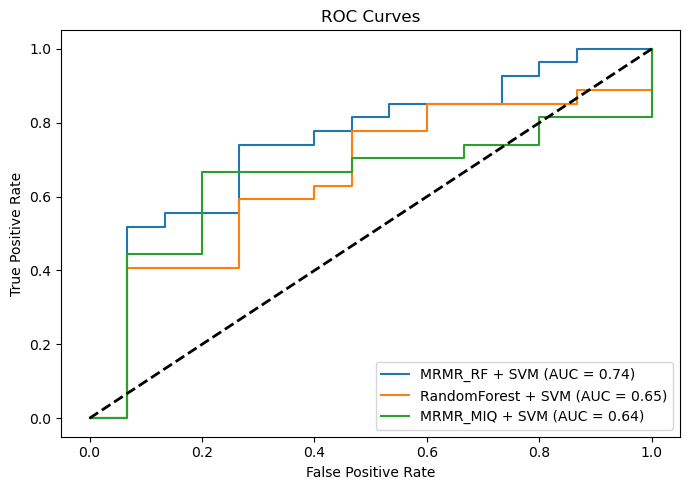

In [18]:
# Select the top 3 models based on Test ROC-AUC
top_models = results_df.nlargest(3, 'Test ROC-AUC')  # Selecciona los 3 mejores modelos (ajusta según prefieras)

# Initialize the plot with a specific figure size
plt.figure(figsize=(7, 5))

# Generate ROC curves for the top models
for index, model in top_models.iterrows():
    # Extract classifier name and predicted probabilities
    clf_name = model['Classifier']
    feature_set_name = model['Feature_Set']
    y_pred_prob = model['y_pred_prob']  

    # Calculate ROC curve points
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve for the model
    plt.plot(fpr, tpr, label=f"{feature_set_name} + {clf_name} (AUC = {roc_auc:.2f})")

# Add a reference diagonal line for the ROC curve and labels
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

### Precision - recall curves

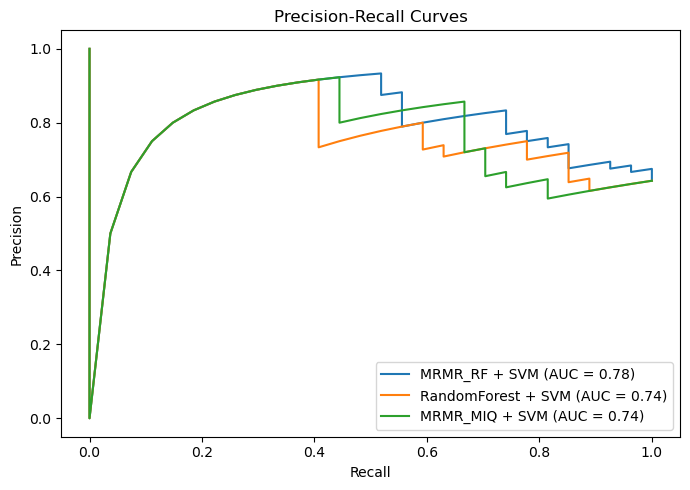

In [19]:
# Select the top 3 models based on 'Test ROC-AUC'
top_models = results_df.nlargest(3, 'Test ROC-AUC')  # Selecciona los 3 mejores modelos (ajusta el criterio si lo prefieres)

# Create a new figure for the Precision-Recall curves
plt.figure(figsize=(7, 5))

# Generate and plot Precision-Recall curves
for index, model in top_models.iterrows():
    # Extract the feature set name, classifier name, and predicted probabilities for the positive class
    feature_set = model['Feature_Set']
    clf_name = model['Classifier']
    y_pred_prob = model['y_pred_prob']  

    # Calculate Precision and Recall values and the corresponding thresholds
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
    pr_auc = auc(recall, precision)

    # Plot the Precision-Recall curve with a label showing the feature set, classifier, and PR AUC
    plt.plot(recall, precision, label=f"{feature_set} + {clf_name} (AUC = {pr_auc:.2f})")

# Configure the plot with labels, title, and legend
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


### Confusion Matrices
#### Standar CM

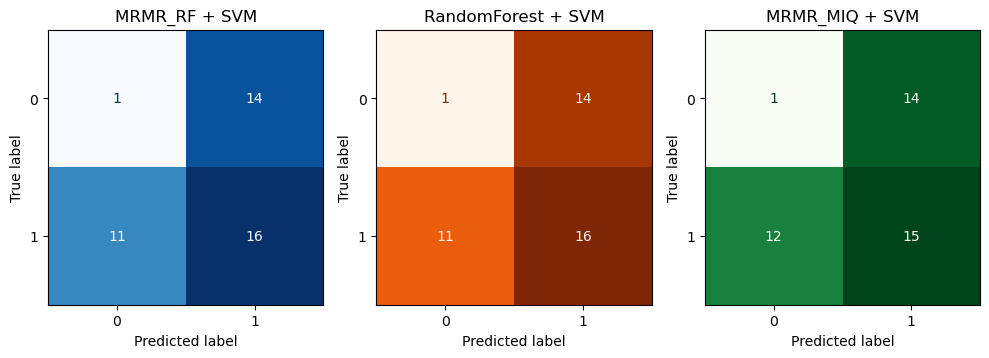

  Feature Selector Classifier Balanced Accuracy F1 Score Precision Recall
0          MRMR_RF        SVM              0.33     0.56      0.53   0.59
1     RandomForest        SVM              0.33     0.56      0.53   0.59
2         MRMR_MIQ        SVM              0.31     0.54      0.52   0.56


In [19]:
# Load the results dataframe from a pickle file
with open('RadiomicClinical_results_df.pkl', 'rb') as f:
    results_df = pickle.load(f)

# Initialize an empty list to store the metrics data
metrics_data = []

# Select the top 3 models based on the 'Test ROC-AUC'
top_models = results_df.nlargest(3, 'Test ROC-AUC')  # Selecciona los 3 mejores modelos

# Create a figure with 3 subplots in a single row
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

# Define custom color schemes for each confusion matrix
color_maps = ['Blues', 'Oranges', 'Greens']  # Colores distintos para cada una

# Generate confusion matrices for the top models
for ax, (_, model), cmap in zip(axes, top_models.iterrows(), color_maps):
    feature_set = model['Feature_Set']
    clf_name = model['Classifier']
    y_pred_test = model['y_pred_test']  # Asegúrate de que esto esté en 'results_df'

    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred_test)
    
    # Plot the confusion matrix with the respective color map
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, cmap=cmap, colorbar=False)  
    
    # Set the title of the subplot
    ax.set_title(f"{feature_set} + {clf_name}")

    # Compute additional metrics
    balanced_acc = balanced_accuracy_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test)
    precision = precision_score(y_test, y_pred_test)
    recall = recall_score(y_test, y_pred_test)
    
    # Store the results in the metrics data list
    metrics_data.append({
        "Feature Selector": feature_set,
        "Classifier": clf_name,
        "Balanced Accuracy": f"{balanced_acc:.2f}",
        "F1 Score": f"{f1:.2f}",
        "Precision": f"{precision:.2f}",
        "Recall": f"{recall:.2f}"
    })

# Adjust the layout of the figure
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajustar para no solapar el título
plt.show()

# Create a DataFrame with the collected metrics data
metrics_df = pd.DataFrame(metrics_data)

# Print the results table
print(metrics_df)

#### F1-score CM

  Feature Selector Classifier Balanced Accuracy F1 Score Precision Recall
0          MRMR_RF        SVM              0.50     0.78      0.64   1.00
1     RandomForest        SVM              0.50     0.78      0.64   1.00
2         MRMR_MIQ        SVM              0.50     0.78      0.64   1.00


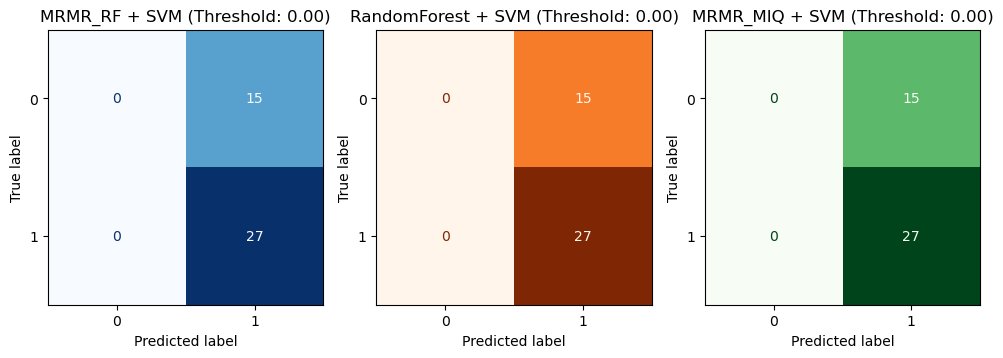

In [21]:
# Load the results dataframe from a pickle file
with open('RadiomicClinical_results_df.pkl', 'rb') as f:
    results_df = pickle.load(f)

# DataFrame to store the results
metrics_data = []

# Seleccionar los mejores modelos (por ejemplo, los 3 mejores modelos basados en ROC-AUC)
top_models = results_df.nlargest(3, 'Test ROC-AUC')  # Selecciona los 3 mejores modelos

# Crear figura con 3 subplots en una sola fila
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

# Esquemas de colores personalizados para cada matriz
color_maps = ['Blues', 'Oranges', 'Greens']  # Colores distintos para cada una

# Definir el rango de umbrales
thresholds = np.arange(0.0, 1.1, 0.01)

# Generar las matrices de confusión para los mejores modelos
for ax, (_, model), cmap in zip(axes, top_models.iterrows(), color_maps):
    # Extraer el nombre del modelo y las predicciones
    feature_set = model['Feature_Set']
    clf_name = model['Classifier']
    y_pred_prob = model['y_pred_prob']  # Asegúrate de que esto esté en 'results_df'
    
    # Calcular el mejor umbral basado en el F1-score
    f1_scores = [f1_score(y_test, (y_pred_prob >= t).astype(int)) for t in thresholds]
    best_threshold = thresholds[np.argmax(f1_scores)]  # Umbral óptimo basado en el mejor F1 score
    y_pred_adjusted = (y_pred_prob >= best_threshold).astype(int)  # Ajustar las predicciones

    # Calcular la matriz de confusión
    cm = confusion_matrix(y_test, y_pred_adjusted)
    
    # Visualizar la matriz de confusión con el esquema de colores correspondiente
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, cmap=cmap, colorbar=False)  # Asignar un cmap diferente por modelo
    
    # Configurar el título del subplot
    ax.set_title(f"{feature_set} + {clf_name} (Threshold: {best_threshold:.2f})")

    # Calcular métricas
    balanced_acc = balanced_accuracy_score(y_test, y_pred_adjusted)
    f1 = f1_score(y_test, y_pred_adjusted)
    precision = precision_score(y_test, y_pred_adjusted)
    recall = recall_score(y_test, y_pred_adjusted)
    
    # Almacenar los resultados en la lista
    metrics_data.append({
        "Feature Selector": feature_set,
        "Classifier": clf_name,
        "Balanced Accuracy": f"{balanced_acc:.2f}",
        "F1 Score": f"{f1:.2f}",
        "Precision": f"{precision:.2f}",
        "Recall": f"{recall:.2f}"
    })

# Crear un DataFrame con los resultados
metrics_df = pd.DataFrame(metrics_data)

# Mostrar la tabla de resultados
print(metrics_df)
    
# Ajustar el layout de la figura
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajustar para no solapar el título
plt.show()


#### Youden Index CM

  Feature Selector Classifier Balanced Accuracy F1 Score Precision Recall
0          MRMR_RF        SVM              0.74     0.78      0.83   0.74
1     RandomForest        SVM              0.67     0.56      0.92   0.41
2         MRMR_MIQ        SVM              0.73     0.75      0.86   0.67


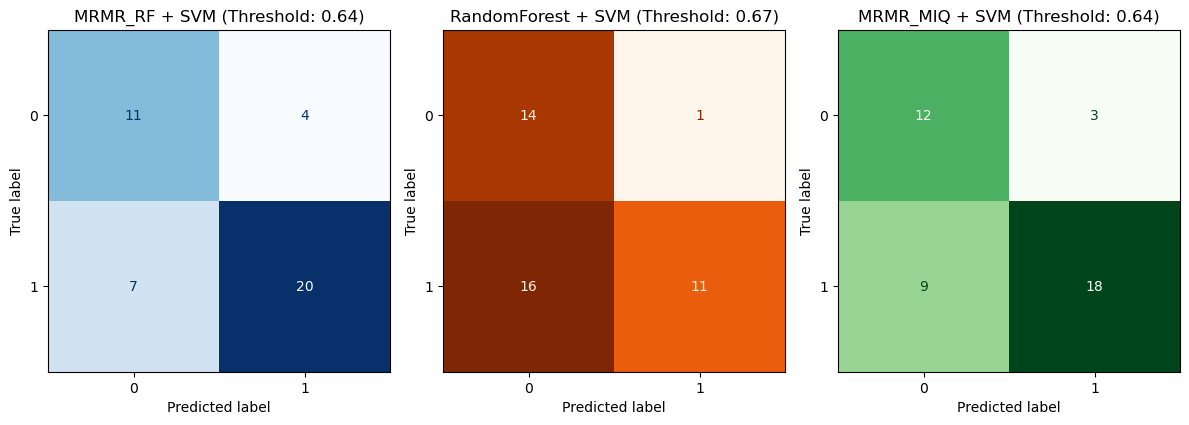

In [22]:
with open('RadiomicClinical_results_df.pkl', 'rb') as f:
    results_df = pickle.load(f)

# DataFrame to store the results
metrics_data = []

# Seleccionar los mejores modelos (por ejemplo, los 3 mejores modelos basados en ROC-AUC)
top_models = results_df.nlargest(3, 'Test ROC-AUC')  # Selecciona los 3 mejores modelos

# Crear figura con 3 subplots en una sola fila
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

# Esquemas de colores personalizados para cada matriz
color_maps = ['Blues', 'Oranges', 'Greens']  # Colores distintos para cada una

# Definir el rango de umbrales
thresholds = np.arange(0.0, 1.1, 0.01)

# Generar las matrices de confusión para los mejores modelos
for ax, (_, model), cmap in zip(axes, top_models.iterrows(), color_maps):
    # Extraer el nombre del modelo y las predicciones
    feature_set = model['Feature_Set']
    clf_name = model['Classifier']
    y_pred_prob = model['y_pred_prob']  # Asegúrate de que esto esté en 'results_df'
    
    # Calcular el Youden Index para diferentes umbrales
    fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_prob)
    youden_index = tpr - fpr  # Youden Index = Sensitivity + Specificity - 1
    best_threshold = thresholds_roc[np.argmax(youden_index)]  # Umbral óptimo según el Youden Index
    y_pred_adjusted = (y_pred_prob >= best_threshold).astype(int)  # Ajustar las predicciones

    # Calcular la matriz de confusión
    cm = confusion_matrix(y_test, y_pred_adjusted)
    
    # Visualizar la matriz de confusión con el esquema de colores correspondiente
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, cmap=cmap, colorbar=False)  # Asignar un cmap diferente por modelo
    
    # Configurar el título del subplot
    ax.set_title(f"{feature_set} + {clf_name} (Threshold: {best_threshold:.2f})")

    # Calcular métricas
    balanced_acc = balanced_accuracy_score(y_test, y_pred_adjusted)
    f1 = f1_score(y_test, y_pred_adjusted)
    precision = precision_score(y_test, y_pred_adjusted)
    recall = recall_score(y_test, y_pred_adjusted)
    
    # Almacenar los resultados en la lista
    metrics_data.append({
        "Feature Selector": feature_set,
        "Classifier": clf_name,
        "Balanced Accuracy": f"{balanced_acc:.2f}",
        "F1 Score": f"{f1:.2f}",
        "Precision": f"{precision:.2f}",
        "Recall": f"{recall:.2f}"
    })

# Crear un DataFrame con los resultados
metrics_df = pd.DataFrame(metrics_data)

# Mostrar la tabla de resultados
print(metrics_df)

# Ajustar el layout de la figura
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajustar para no solapar el título
plt.show()


### Results Heatmap

In [ ]:
# Select the key metrics for the heatmap
metrics = ['CV ROC-AUC', 'CV Balanced Accuracy', 'CV F1-Score', 'CV Precision', 'CV Recall', 
           'Test ROC-AUC','Test Balanced Accuracy', 'Test F1-Score','Test Precision', 'Test Recall']

# Create a combined column with 'Feature_Set' and 'Classifier'
results_df['Model'] = results_df['Feature_Set'] + ' + ' + results_df['Classifier']

# Filter the metrics and set the new 'Model' column as the index
heatmap_data = results_df[metrics + ['Model']].set_index('Model')

# Generate the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".3f", cbar_kws={'label': 'Score'}, vmin=0.3, vmax=1)
plt.title('Heatmap for performance metrics of radiomic and some clinical variables-based predictive model')
plt.ylabel('Feature Set + Classifier')
plt.xlabel('Metrics')
plt.tight_layout()
plt.show()

# Balanced clinical and radiomic data - Oversampling methods

## Training and testing

In [ ]:
# Dictionary of classifiers
clfs = {
    'RandomForest': RandomForestClassifier(random_state=2024, class_weight="balanced"),
    'LogisticRegression': LogisticRegression(random_state=2024, max_iter=1000, class_weight="balanced"),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True, random_state=2024, class_weight="balanced"),
    'XGBoost': xgb.XGBClassifier(objective="binary:logistic", random_state=2024),
    'MLPC': MLPClassifier(random_state=2024)
}

# Scoring dictionary
scoring = {
    'roc_auc': 'roc_auc',
    'balanced_accuracy': make_scorer(balanced_accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

# Dictionary of oversampling methods
OvSampl = {
    'SMOTE': SMOTE(random_state=2024, k_neighbors=5),
    'SMOTETomek': SMOTETomek(random_state=2024),
    'ADASYN': ADASYN(random_state=2024),
    'RandomOverSampler': RandomOverSampler(random_state=2024)
}

# List to store results
results = []

# Define cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2024)

# Load the radiomic feature sets
with open('radiomic_feature_sets.pkl', 'rb') as f:
    radiomic_feature_sets = pickle.load(f)

# Iterate over each feature set
for feature_set_name, selected_features in radiomic_feature_sets.items():
    if len(selected_features) != 0:
        # Create a list of features to select by combining the current set of features with additional ones.
        additional_features = list(set(selected_by_majority.index) - set(selected_features))  # Exclude duplicates
        to_select = list(selected_features) + additional_features
        X_train = x_train[to_select]
        X_test = x_test[to_select]
        
        # Iterate over each oversampling method
        for ovsampl_name, ovsampl_method in OvSampl.items():
            X_train_resampled, y_train_resampled = ovsampl_method.fit_resample(X_train, y_train)
            
            # Iterate over each classifier
            for clf_name, clf in clfs.items():
                # Perform cross-validation
                cv_results = cross_validate(
                    clf, X_train_resampled, y_train_resampled, scoring=scoring, cv=cv, return_train_score=True
                )
                
                # Train the classifier
                clf.fit(X_train_resampled, y_train_resampled)
                
                # Prediction on the test set
                y_pred_prob = clf.predict_proba(X_test)[:, 1]
                y_pred_test = clf.predict(X_test)
                
                # Store the results
                results.append({
                    'Feature_Set': feature_set_name,
                    'Classifier': clf_name,
                    'Oversampling_method': ovsampl_name,
                    'y_pred_prob': y_pred_prob,
                    'y_pred_test': y_pred_test,
                    'CV ROC-AUC': cv_results['test_roc_auc'].mean(),
                    'CV ROC-AUC (std)': cv_results['test_roc_auc'].std(),
                    'CV Balanced Accuracy': cv_results['test_balanced_accuracy'].mean(),
                    'CV Precision': cv_results['test_precision'].mean(),
                    'CV Recall': cv_results['test_recall'].mean(),
                    'CV F1-Score': cv_results['test_f1'].mean(),
                    'Test Balanced Accuracy': balanced_accuracy_score(y_test, y_pred_test),
                    'Test Precision': precision_score(y_test, y_pred_test),
                    'Test Recall': recall_score(y_test, y_pred_test),
                    'Test F1-Score': f1_score(y_test, y_pred_test),
                    'Test ROC-AUC': roc_auc_score(y_test, y_pred_prob)
                })

# Convert the results into a DataFrame
results_df = pd.DataFrame(results)

# Save results to a pickle file
with open('RadiomicClinical_OS_results_df.pkl', 'wb') as f:
     pickle.dump(results_df, f)


c:\Users\pcbox\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\pcbox\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\pcbox\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\pcbox\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\pcbox\anaconda3\Lib\site-packages\sklearn\neural_network\_multi

## Results Table

In [27]:
# Sort the table by Test ROC-AUC
sorted_results_df = results_df.sort_values(by='Test ROC-AUC', ascending=False)

# Select important columns for display
columns_to_display = [
    'Feature_Set', 'Oversampling_method', 'Classifier', 'CV ROC-AUC', 'CV ROC-AUC (std)', 'CV Balanced Accuracy', 'CV Precision',
     'CV Recall','CV F1-Score','Test Balanced Accuracy', 'Test Precision', 
    'Test Recall', 'Test F1-Score', 'Test ROC-AUC'
]

# Filter and display
results_table = sorted_results_df[columns_to_display].round(3)

# Display the table (top 10 rows)
display(results_table.head(10))
results_table.to_excel('SOMEclinicalANDradiomic_model_results_OS.xlsx', index=False)

Feature_Set Oversampling_method    Classifier  CV ROC-AUC  \
14          ANOVA              ADASYN           KNN       0.600   
108        Optuna              ADASYN  RandomForest       0.861   
102        Optuna          SMOTETomek  RandomForest       0.873   
42   RandomForest   RandomOverSampler  RandomForest       0.922   
36   RandomForest              ADASYN  RandomForest       0.851   
60       MRMR_MIQ              ADASYN  RandomForest       0.869   
117        Optuna   RandomOverSampler           SVM       0.670   
22          ANOVA   RandomOverSampler       XGBoost       0.840   
66       MRMR_MIQ   RandomOverSampler  RandomForest       0.894   
116        Optuna   RandomOverSampler           KNN       0.637   

     CV ROC-AUC (std)  CV Balanced Accuracy  CV Precision  CV Recall  \
14              0.112                 0.596         0.645      0.499   
108             0.061                 0.757         0.797      0.710   
102             0.051                 0.779         0.811      0.729   
42              0.079                 0.821         0.847      0.803   
36              0.116                 0.761         0.771      0.771   
60              0.088                 0.797         0.783      0.823   
117             0.080                 0.621         0.656      0.501   
22              0.088                 0.782         0.809      0.755   
66              0.113                 0.815         0.868      0.740   
116             0.036                 0.564         0.589      0.417   

     CV F1-Score  Test Balanced Accuracy  Test Precision  Test Recall  \
14         0.544                   0.581           0.708        0.630   
108        0.737                   0.567           0.692        0.667   
102        0.749                   0.533           0.667        0.667   
42         0.812                   0.585           0.704        0.704   
36         0.753                   0.604           0.714        0.741   
60         0.797                   0.533           0.667        0.667   
117        0.567                   0.489           0.632        0.444   
22         0.773                   0.585           0.704        0.704   
66         0.794                   0.567           0.692        0.667   
116        0.487                   0.493           0.636        0.519   

     Test F1-Score  Test ROC-AUC  
14           0.667         0.604  
108          0.679         0.559  
102          0.667         0.554  
42           0.704         0.551  
36           0.727         0.549  
60           0.667         0.542  
117          0.522         0.533  
22           0.704         0.533  
66           0.679         0.533  
116          0.571         0.532

## Results Heatmap

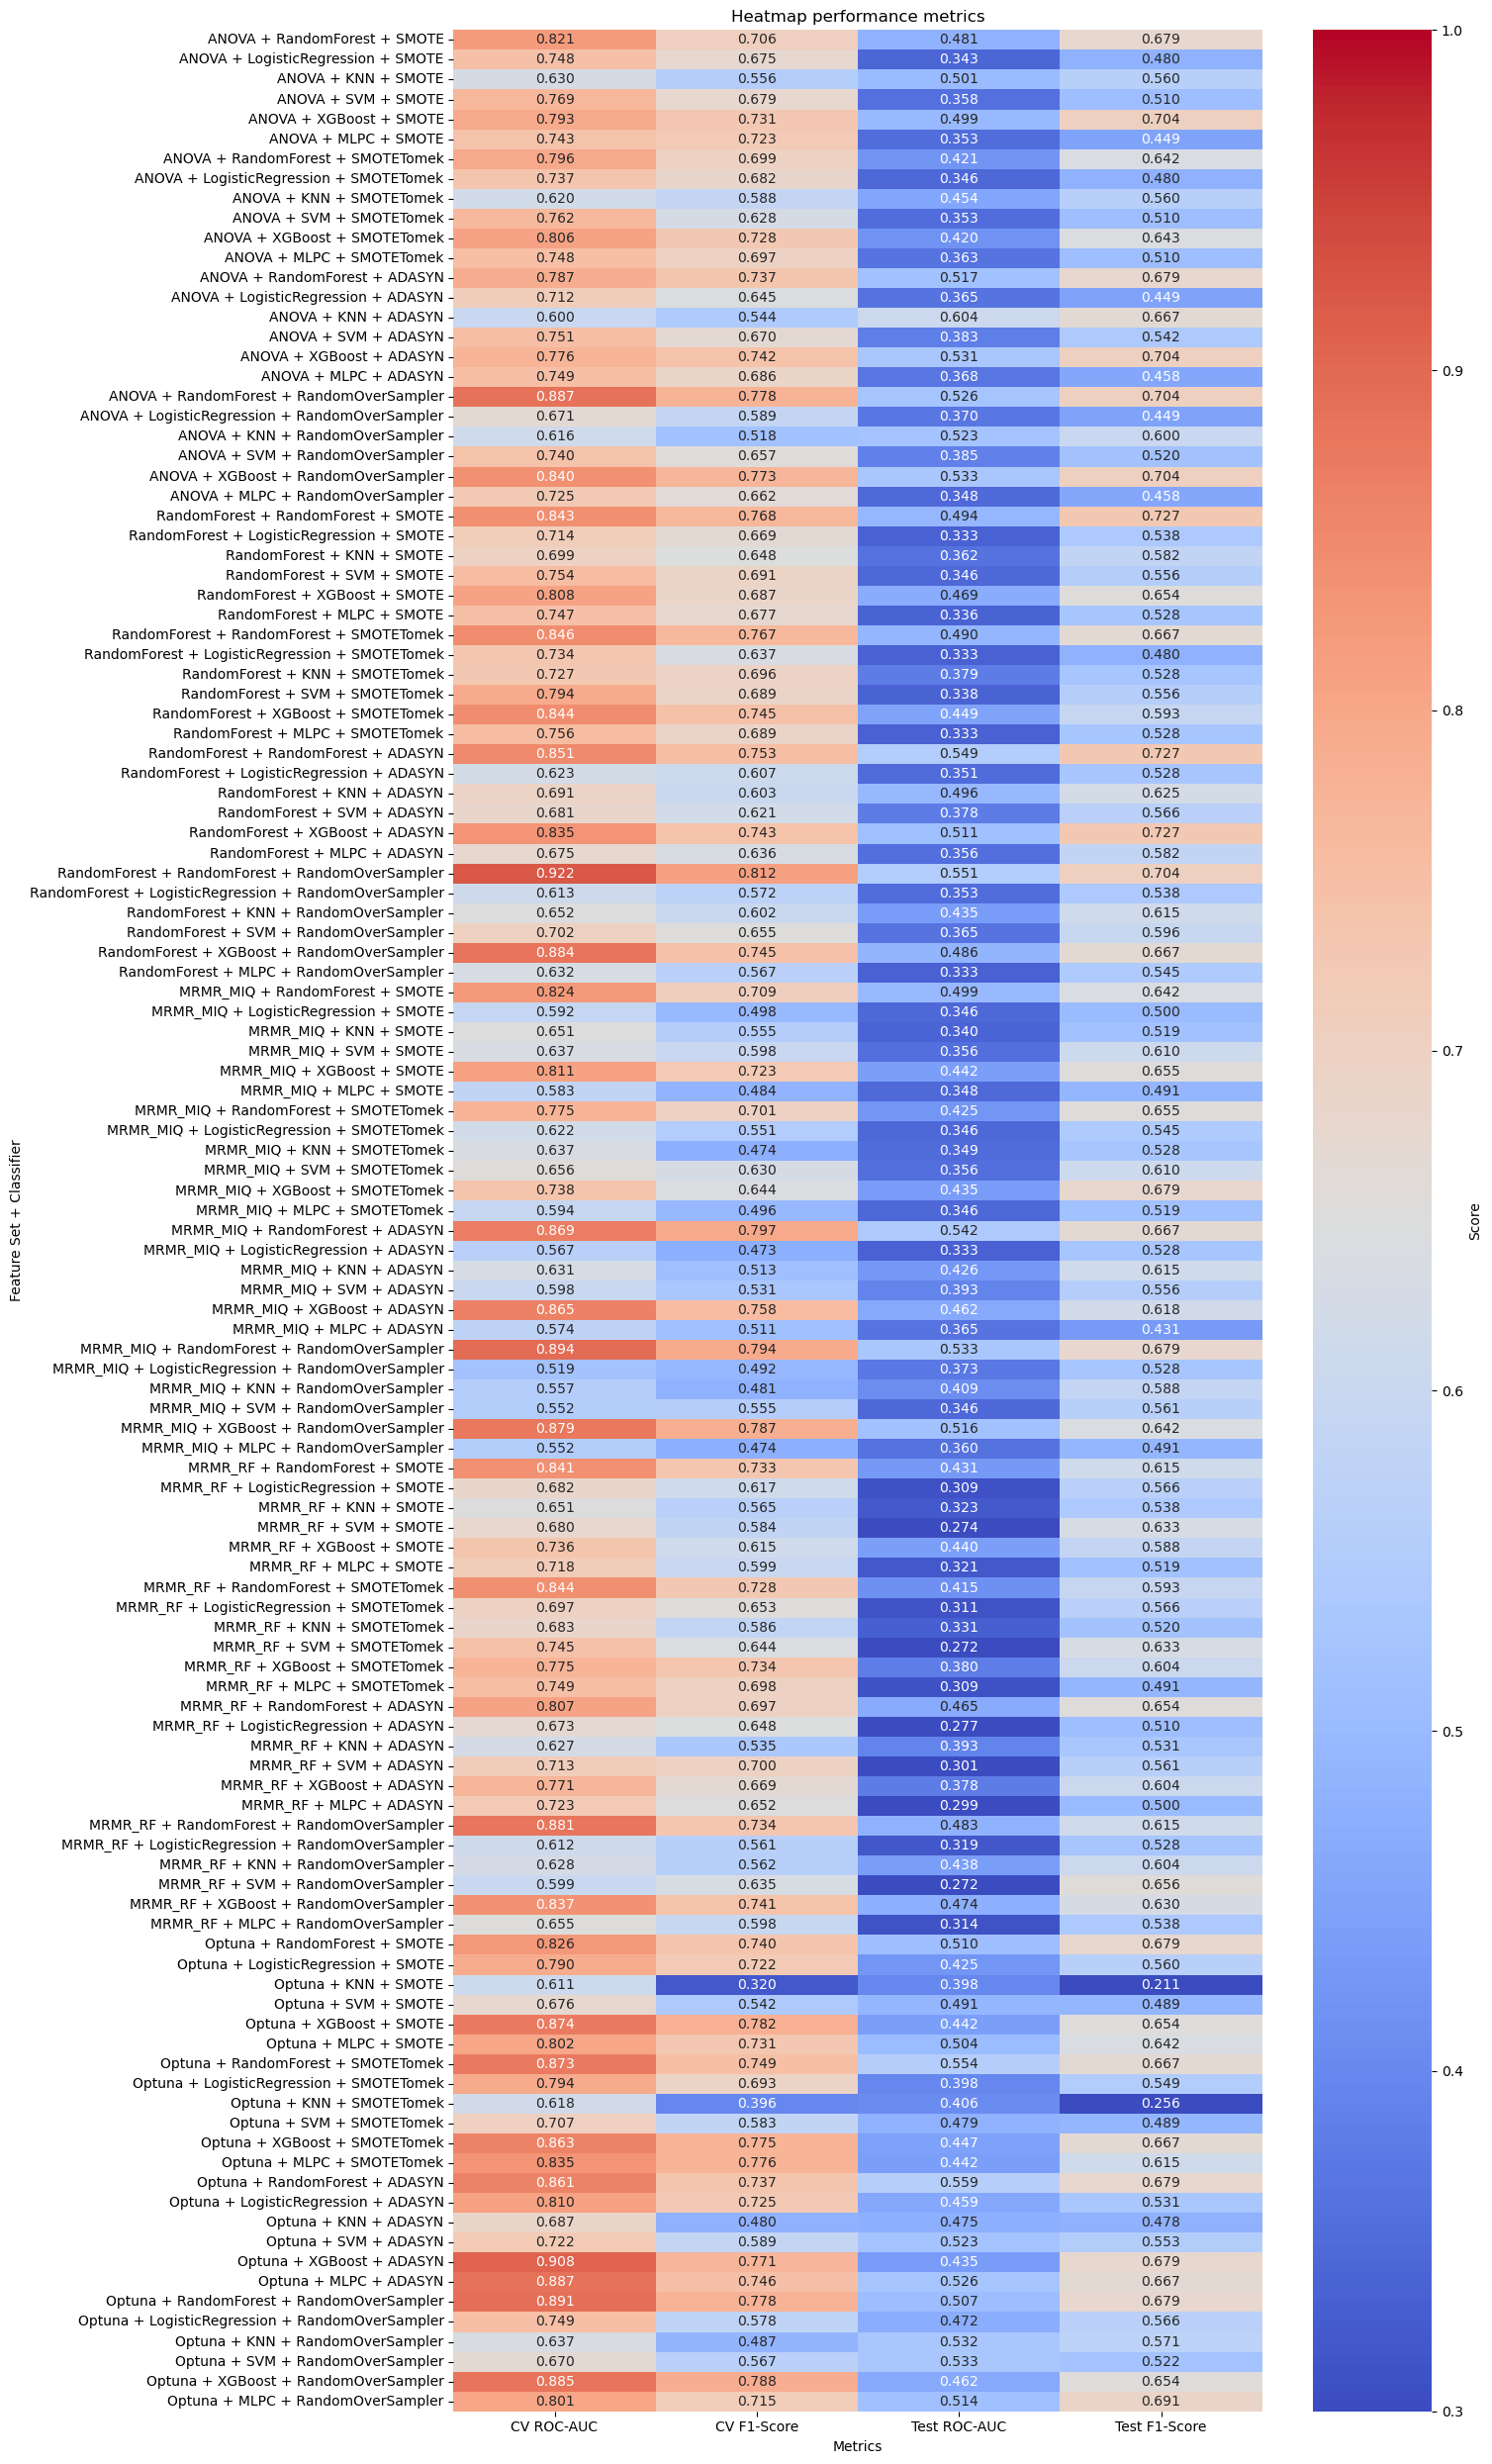

In [29]:
# Select the key metrics for the heatmap
metrics = ['CV ROC-AUC', 'CV F1-Score', 'Test ROC-AUC', 'Test F1-Score']

# Create a combined column with 'Feature_Set' , 'Classifier' and 'Oversapling method'
results_df['Model'] = results_df['Feature_Set'] + ' + ' + results_df['Classifier'] + ' + ' + results_df['Oversampling_method']

# Filter the metrics and set the new 'Model' column as the index
heatmap_data = results_df[metrics + ['Model']].set_index('Model')

# Generate the heatmap
plt.figure(figsize=(15, 25))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".3f", cbar_kws={'label': 'Score'}, vmin=0.3, vmax=1)
plt.title('Heatmap performance metrics')
plt.ylabel('Feature Set + Classifier')
plt.xlabel('Metrics')
plt.tight_layout()
plt.show()

# Balanced clinical and radiomic data models - Random Search CV hyperparameter tunning

## Training and testing

In [42]:
# Dictionary of classifiers
clfs = {
    'RandomForest': RandomForestClassifier(random_state=2024, class_weight="balanced"),
    'LogisticRegression': LogisticRegression(random_state=2024, max_iter=1000, class_weight="balanced"),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True, random_state=2024, class_weight="balanced"),
    'XGBoost': xgb.XGBClassifier(objective="binary:logistic", random_state=2024),
    'MLPC': MLPClassifier(random_state=2024)
}

# Scoring dictionary
scoring = {
    'roc_auc': 'roc_auc',
    'balanced_accuracy': make_scorer(balanced_accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

# Hyperparameter grid for each classifier
param_distributions = {
    'RandomForest': {
        'n_estimators': randint(50, 200),
        'max_depth': randint(3, 15),
        'min_samples_split': randint(2, 10),
        'min_samples_leaf': randint(1, 5),
        'bootstrap': [True, False]
    },
    'LogisticRegression': {
        'C': uniform(0.01, 10),
        'solver': ['liblinear', 'lbfgs'],
        'penalty': ['l1', 'l2']
    },
    'KNN': {
        'n_neighbors': randint(3, 10),
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    'SVM': {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto'], 
        'probability': [True]
    },
    'XGBoost': {
        'n_estimators': randint(50, 200),
        'learning_rate': uniform(0.01, 0.2),
        'max_depth': randint(3, 10),
        'subsample': uniform(0.6, 0.4),
        'colsample_bytree': uniform(0.6, 0.4)
    },
    'MLPC': {
        'hidden_layer_sizes': [(50, 30), (30, 20), (20,)],
        'max_iter': [100, 200, 300],
        'activation': ['relu', 'logistic'],
        'solver': ['adam', 'lbfgs'],
        'alpha': [0.0001, 0.001],
        'learning_rate': ['constant', 'adaptive'],
        'early_stopping': [True]
    }
}

# List to store results
results = []

# Define cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2024)

# Load the radiomic feature sets
with open('radiomic_feature_sets.pkl', 'rb') as f:
    radiomic_feature_sets = pickle.load(f)

# Iterate over each feature set
for feature_set_name, selected_features in radiomic_feature_sets.items():
    if len(selected_features) != 0:
        # Create a list of features to select by combining the current set of features with additional ones.
         additional_features = list(set(selected_by_majority.index) - set(selected_features))  # Exclude duplicates
         to_select = list(selected_features) + additional_features
         X_train = x_train[to_select]
         X_test = x_test[to_select]
         
        # Iterate over each classifier
         for clf_name, clf in clfs.items():
             # Perform RandomizedSearchCV for hyperparameter tuning
             random_search = RandomizedSearchCV(
                clf,
                param_distributions[clf_name],  # Hyperparameter grid for the classifier
                n_iter=50,
                cv=cv,
                scoring='roc_auc',
                random_state=2024,
                n_jobs=-1
            )
             
            # Fit the RandomizedSearchCV model on the training data
             random_search.fit(X_train, y_train)

             # Best model 
             best_model = random_search.best_estimator_
            
             # Re-do cross-validation with the best model
             cv_results = cross_validate(
                            best_model, X_train, y_train, scoring=scoring, cv=cv, return_train_score=True
                            )
 
            # Predictions on the test set
             y_pred_prob = best_model.predict_proba(X_test)[:, 1]
             y_pred_test = best_model.predict(X_test)
            
            # Save the results
             results.append({
            'Feature_Set': feature_set_name,
            'Classifier': clf_name,
            'Best Params': random_search.best_params_,
            'y_pred_prob': y_pred_prob,
            'y_pred_test': y_pred_test,
            'CV ROC-AUC': cv_results['test_roc_auc'].mean(),
            'CV ROC-AUC (std)': cv_results['test_roc_auc'].std(),
            'CV Balanced Accuracy': cv_results['test_balanced_accuracy'].mean(),
            'CV Precision': cv_results['test_precision'].mean(),
            'CV Recall': cv_results['test_recall'].mean(),
            'CV F1-Score': cv_results['test_f1'].mean(),
            'Test Balanced Accuracy': balanced_accuracy_score(y_test, y_pred_test),
            'Test Precision': precision_score(y_test, y_pred_test),
            'Test Recall': recall_score(y_test, y_pred_test),
            'Test F1-Score': f1_score(y_test, y_pred_test),
            'Test ROC-AUC': roc_auc_score(y_test, y_pred_prob)
              })

# Convert the results into a DataFrame
results_df = pd.DataFrame(results)

# Save results to a pickle file
with open('RadiomicClinical_RandomSearch_results_df.pkl', 'wb') as f:
     pickle.dump(results_df, f)

c:\Users\pcbox\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
35 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\pcbox\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\pcbox\anaconda3\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\pcbox\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1194, in fit
    solver = 

### Results table

In [43]:
# Sort the table by Test ROC-AUC
sorted_results_df = results_df.sort_values(by='Test ROC-AUC', ascending=False)

# Select important columns for display
columns_to_display = [
    'Feature_Set', 'Classifier', 'Best Params', 'CV ROC-AUC', 'CV ROC-AUC (std)', 'CV Balanced Accuracy', 'CV Precision',
     'CV Recall','CV F1-Score','Test Balanced Accuracy', 'Test Precision', 
    'Test Recall', 'Test F1-Score', 'Test ROC-AUC'
]

# Filter and display
results_table = sorted_results_df[columns_to_display].round(3)

# Display the table (top 10 rows)
display(results_table.head(10))
results_table.to_excel('SOMEclinicalANDradiomic_model_results_Hyperparams.xlsx', index=False)

Feature_Set    Classifier  \
15      MRMR_MIQ           SVM   
26        Optuna           KNN   
6   RandomForest  RandomForest   
24        Optuna  RandomForest   
10  RandomForest       XGBoost   
12      MRMR_MIQ  RandomForest   
23       MRMR_RF          MLPC   
2          ANOVA           KNN   
0          ANOVA  RandomForest   
4          ANOVA       XGBoost   

                                          Best Params  CV ROC-AUC  \
15  {'probability': True, 'kernel': 'linear', 'gam...       0.605   
26  {'metric': 'manhattan', 'n_neighbors': 9, 'wei...       0.542   
6   {'bootstrap': False, 'max_depth': 3, 'min_samp...       0.816   
24  {'bootstrap': False, 'max_depth': 14, 'min_sam...       0.573   
10  {'colsample_bytree': 0.6630020416550897, 'lear...       0.771   
12  {'bootstrap': False, 'max_depth': 12, 'min_sam...       0.664   
23  {'solver': 'lbfgs', 'max_iter': 200, 'learning...       0.632   
2   {'metric': 'manhattan', 'n_neighbors': 4, 'wei...       0.666   
0   {'bootstrap': True, 'max_depth': 6, 'min_sampl...       0.700   
4   {'colsample_bytree': 0.6242995322280628, 'lear...       0.694   

    CV ROC-AUC (std)  CV Balanced Accuracy  CV Precision  CV Recall  \
15             0.100                 0.521         0.672      0.613   
26             0.176                 0.493         0.648      0.824   
6              0.113                 0.759         0.838      0.851   
24             0.155                 0.578         0.697      0.790   
10             0.108                 0.642         0.728      0.983   
12             0.123                 0.575         0.703      0.774   
23             0.085                 0.592         0.712      0.756   
2              0.088                 0.541         0.677      0.787   
0              0.110                 0.646         0.745      0.806   
4              0.129                 0.615         0.724      0.806   

    CV F1-Score  Test Balanced Accuracy  Test Precision  Test Recall  \
15        0.628                   0.396           0.571        0.593   
26        0.722                   0.567           0.692        0.667   
6         0.839                   0.589           0.700        0.778   
24        0.739                   0.567           0.692        0.667   
10        0.836                   0.474           0.629        0.815   
12        0.733                   0.567           0.692        0.667   
23        0.731                   0.448           0.607        0.630   
2         0.724                   0.467           0.621        0.667   
0         0.769                   0.567           0.692        0.667   
4         0.759                   0.604           0.714        0.741   

    Test F1-Score  Test ROC-AUC  
15          0.582         0.605  
26          0.679         0.575  
6           0.737         0.548  
24          0.679         0.546  
10          0.710         0.543  
12          0.679         0.528  
23          0.618         0.526  
2           0.643         0.511  
0           0.679         0.501  
4           0.727         0.499

### Roc cuves

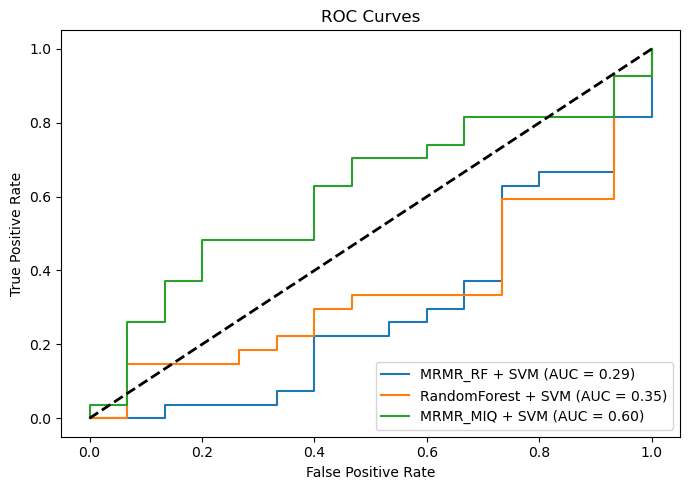

In [44]:
# Load the results DataFrame from a pickle file
with open('RadiomicClinical_RandomSearch_results_df.pkl', 'rb') as f:
    results_df = pickle.load(f)

# DataFrame to store the results
metrics_data = []

# Select the best models (SVM y los Feature Sets MRM_RF, RF, MRMR_MIQ)
top_models = results_df[(results_df['Classifier'] == 'SVM') & 
                        (results_df['Feature_Set'].isin(['MRMR_RF', 'RandomForest', 'MRMR_MIQ']))]

# Sort the models by the desired order of feature sets
feature_set_order = ['MRMR_RF', 'RandomForest', 'MRMR_MIQ']
top_models = top_models[top_models['Feature_Set'].isin(feature_set_order)]
top_models['Feature_Set'] = pd.Categorical(top_models['Feature_Set'], categories=feature_set_order, ordered=True)
top_models = top_models.sort_values('Feature_Set')

# Create a figure for the ROC curves
plt.figure(figsize=(7, 5))

# Generate ROC curves for the top models
for index, model in top_models.iterrows():
    clf_name = model['Classifier']
    feature_set_name = model['Feature_Set']
    y_pred_prob = model['y_pred_prob']  # Asegúrate de que estas probabilidades estén almacenadas

    # Calculate ROC curve points (False Positive Rate, True Positive Rate)
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve for the current model
    plt.plot(fpr, tpr, label=f"{feature_set_name} + {clf_name} (AUC = {roc_auc:.2f})")

# Add a reference diagonal line (random model performance)
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Add labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


### Precision recall curves

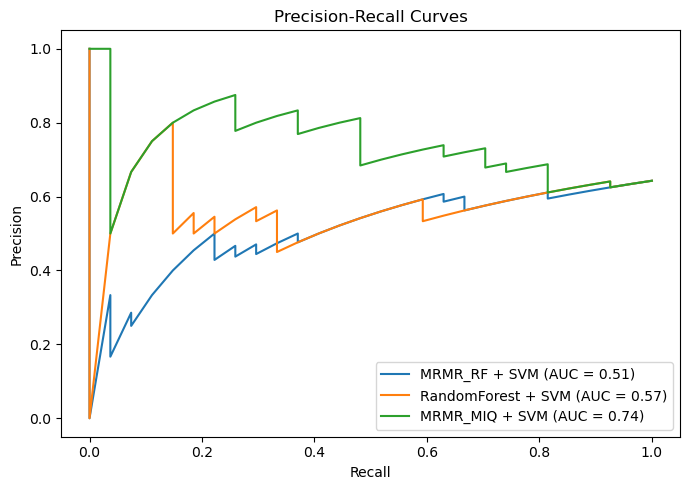

In [45]:
with open('RadiomicClinical_RandomSearch_results_df.pkl', 'rb') as f:
    results_df = pickle.load(f)

# DataFrame to store the results
metrics_data = []

# Select the top 3 models (SVM y los Feature Sets MRM_RF, RF, MRMR_MIQ)
top_models = results_df[(results_df['Classifier'] == 'SVM') & 
                        (results_df['Feature_Set'].isin(['MRMR_RF', 'RandomForest', 'MRMR_MIQ']))]

# Reorder models based on the predefined feature set order
feature_set_order = ['MRMR_RF', 'RandomForest', 'MRMR_MIQ']
top_models = top_models[top_models['Feature_Set'].isin(feature_set_order)]
top_models['Feature_Set'] = pd.Categorical(top_models['Feature_Set'], categories=feature_set_order, ordered=True)
top_models = top_models.sort_values('Feature_Set')

# Create figure for Precision-Recall curves
plt.figure(figsize=(7, 5))

# Generate Precision-Recall curves for the top models
for index, model in top_models.iterrows():
    # Extract classifier name, feature set, and predicted probabilities
    feature_set = model['Feature_Set']
    clf_name = model['Classifier']
    y_pred_prob = model['y_pred_prob']  

    # Calculate Precision-Recall curve points
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
    pr_auc = auc(recall, precision)

    # Plot the Precision-Recall curve for the model
    plt.plot(recall, precision, label=f"{feature_set} + {clf_name} (AUC = {pr_auc:.2f})")

# Display the plot
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="lower right")  
plt.tight_layout()
plt.show()


### Confusion matrices 

#### Standard CM

  Feature Selector Classifier Balanced Accuracy F1 Score Precision Recall
0          MRMR_RF        SVM              0.37     0.51      0.54   0.48
1     RandomForest        SVM              0.41     0.57      0.58   0.56
2         MRMR_MIQ        SVM              0.40     0.58      0.57   0.59


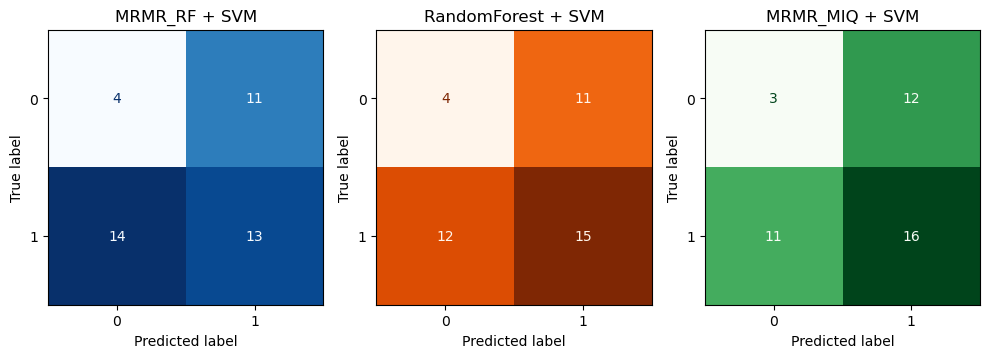

In [21]:
# Load the results dataframe from a pickle file
with open('RadiomicClinical_RandomSearch_results_df.pkl', 'rb') as f:
    results_df = pickle.load(f)

# DataFrame to store the results
metrics_data = []

# Select the top 3 models based on the 'Test ROC-AUC' (SVM y los Feature Sets MRM_RF, RF, MRMR_MIQ)
top_models = results_df[(results_df['Classifier'] == 'SVM') & 
                        (results_df['Feature_Set'].isin(['MRMR_RF', 'RandomForest', 'MRMR_MIQ']))]

# Reordering
feature_set_order = ['MRMR_RF', 'RandomForest', 'MRMR_MIQ']
top_models = top_models[top_models['Feature_Set'].isin(feature_set_order)]
top_models['Feature_Set'] = pd.Categorical(top_models['Feature_Set'], categories=feature_set_order, ordered=True)
top_models = top_models.sort_values('Feature_Set')

# Create a figure with 3 subplots in a single row
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

# Define custom color schemes for each confusion matrix
color_maps = ['Blues', 'Oranges', 'Greens']  # Colores distintos para cada una

# Generate confusion matrices for the top models
for ax, (_, model), cmap in zip(axes, top_models.iterrows(), color_maps):
    # Extract the feature set name, classifier name, and the model's test predictions
    feature_set = model['Feature_Set']
    clf_name = model['Classifier']
    y_pred_test = model['y_pred_test']  # Asegúrate de que esto esté en 'results_df'

    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred_test)
    
    # Plot the confusion matrix with the respective color map
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, cmap=cmap, colorbar=False)  # Asignar un cmap diferente por modelo
    
    # Set the title of the subplot
    ax.set_title(f"{feature_set} + {clf_name}")

    # Compute additional metrics
    balanced_acc = balanced_accuracy_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test)
    precision = precision_score(y_test, y_pred_test)
    recall = recall_score(y_test, y_pred_test)
    
    # Store the results in the metrics data list
    metrics_data.append({
        "Feature Selector": feature_set,
        "Classifier": clf_name,
        "Balanced Accuracy": f"{balanced_acc:.2f}",
        "F1 Score": f"{f1:.2f}",
        "Precision": f"{precision:.2f}",
        "Recall": f"{recall:.2f}"
    })

# Create a DataFrame with the collected metrics data
metrics_df = pd.DataFrame(metrics_data)

# Print the results table
print(metrics_df)

# Adjust the layout of the figure
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajustar para no solapar el título
plt.show()

#### Youden Index CM

c:\Users\pcbox\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  Feature Selector Classifier Balanced Accuracy F1 Score Precision Recall
0          MRMR_RF        SVM              0.50     0.00      0.00   0.00
1     RandomForest        SVM              0.54     0.25      0.80   0.15
2         MRMR_MIQ        SVM              0.64     0.60      0.81   0.48


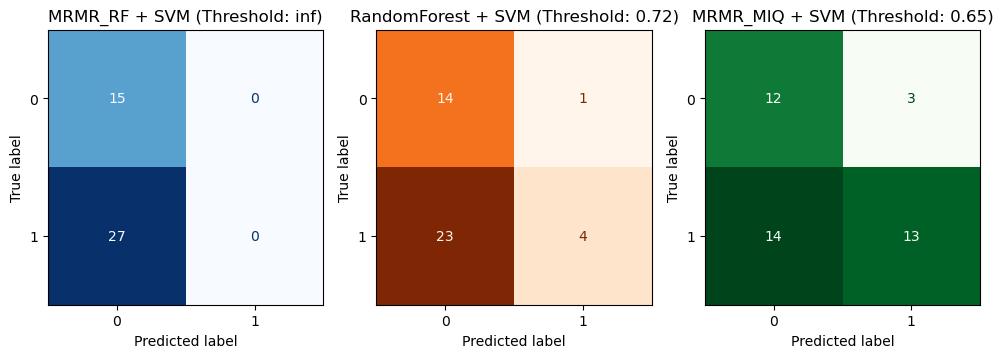

In [22]:
with open('RadiomicClinical_RandomSearch_results_df.pkl', 'rb') as f:
    results_df = pickle.load(f)

# DataFrame to store the results
metrics_data = []

# Seleccionar los mejores modelos (SVM y los Feature Sets MRM_RF, RF, MRMR_MIQ)
top_models = results_df[(results_df['Classifier'] == 'SVM') & 
                        (results_df['Feature_Set'].isin(['MRMR_RF', 'RandomForest', 'MRMR_MIQ']))]

# Ordenar los modelos por el orden deseado
feature_set_order = ['MRMR_RF', 'RandomForest', 'MRMR_MIQ']
top_models = top_models[top_models['Feature_Set'].isin(feature_set_order)]
top_models['Feature_Set'] = pd.Categorical(top_models['Feature_Set'], categories=feature_set_order, ordered=True)
top_models = top_models.sort_values('Feature_Set')

# Crear figura con 3 subplots en una sola fila
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

# Esquemas de colores personalizados para cada matriz
color_maps = ['Blues', 'Oranges', 'Greens']  # Colores distintos para cada una

# Generar las matrices de confusión para los mejores modelos
for ax, (_, model), cmap in zip(axes, top_models.iterrows(), color_maps):
    # Extraer el nombre del modelo y las predicciones
    feature_set = model['Feature_Set']
    clf_name = model['Classifier']
    y_pred_prob = model['y_pred_prob']  # Asegúrate de que esto esté en 'results_df'
    
    # Calcular el Youden Index para diferentes umbrales
    fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_prob)
    youden_index = tpr - fpr  # Youden Index = Sensitivity + Specificity - 1
    best_threshold = thresholds_roc[np.argmax(youden_index)]  # Umbral óptimo según el Youden Index
    y_pred_adjusted = (y_pred_prob >= best_threshold).astype(int)  # Ajustar las predicciones

    # Calcular la matriz de confusión
    cm = confusion_matrix(y_test, y_pred_adjusted)
    
    # Visualizar la matriz de confusión con el esquema de colores correspondiente
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, cmap=cmap, colorbar=False)  # Asignar un cmap diferente por modelo
    
    # Configurar el título del subplot
    ax.set_title(f"{feature_set} + {clf_name} (Threshold: {best_threshold:.2f})")

        # Calcular métricas
    balanced_acc = balanced_accuracy_score(y_test, y_pred_adjusted)
    f1 = f1_score(y_test, y_pred_adjusted)
    precision = precision_score(y_test, y_pred_adjusted)
    recall = recall_score(y_test, y_pred_adjusted)
    
    # Almacenar los resultados en la lista
    metrics_data.append({
        "Feature Selector": feature_set,
        "Classifier": clf_name,
        "Balanced Accuracy": f"{balanced_acc:.2f}",
        "F1 Score": f"{f1:.2f}",
        "Precision": f"{precision:.2f}",
        "Recall": f"{recall:.2f}"
    })

# Crear un DataFrame con los resultados
metrics_df = pd.DataFrame(metrics_data)

# Mostrar la tabla de resultados
print(metrics_df)

# Ajustar el layout de la figura
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajustar para no solapar el título
plt.show()


#### F1-score CM

C:\Users\pcbox\AppData\Local\Temp\ipykernel_20080\1812624617.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_models['Feature_Set'] = pd.Categorical(top_models['Feature_Set'], categories=feature_set_order, ordered=True)


  Feature Selector Classifier Balanced Accuracy F1 Score Precision Recall
0          MRMR_RF        SVM              0.50     0.78      0.64   1.00
1     RandomForest        SVM              0.50     0.78      0.64   1.00
2         MRMR_MIQ        SVM              0.50     0.78      0.64   1.00


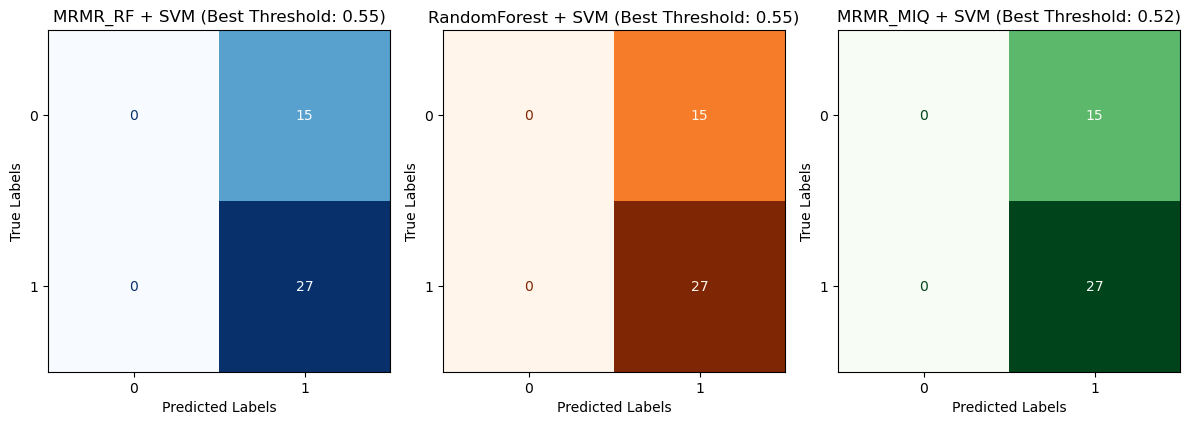

In [23]:
with open('RadiomicClinical_RandomSearch_results_df.pkl', 'rb') as f:
    results_df = pickle.load(f)

# DataFrame to store the results
metrics_data = []

# Select the best models (e.g., SVM with specific feature sets)
top_models = results_df[(results_df['Classifier'] == 'SVM') & 
                        (results_df['Feature_Set'].isin(['MRMR_RF', 'RandomForest', 'MRMR_MIQ']))]

# Sort models by feature set order
feature_set_order = ['MRMR_RF', 'RandomForest', 'MRMR_MIQ']
top_models['Feature_Set'] = pd.Categorical(top_models['Feature_Set'], categories=feature_set_order, ordered=True)
top_models = top_models.sort_values('Feature_Set')

# Create figure with 3 subplots in a single row
fig, axes = plt.subplots(1, 3, figsize=(12, 6))

# Color maps for each confusion matrix
color_maps = ['Blues', 'Oranges', 'Greens']

# Generate confusion matrices for the best models
for ax, (_, model), cmap in zip(axes, top_models.iterrows(), color_maps):
    feature_set = model['Feature_Set']
    clf_name = model['Classifier']
    y_pred_prob = model['y_pred_prob']

    # Compute F1 score for different thresholds to find the optimal threshold
    fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_prob)
    best_f1_score = 0
    best_threshold = 0

    # Iterate over the thresholds to find the one with the maximum F1 score
    for threshold in thresholds_roc:
        y_pred_adjusted = (y_pred_prob >= threshold).astype(int)
        score = f1_score(y_test, y_pred_adjusted)
        if score > best_f1_score:
            best_f1_score = score
            best_threshold = threshold

    # Adjust predictions with the best threshold
    y_pred_adjusted = (y_pred_prob >= best_threshold).astype(int)

    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred_adjusted)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, cmap=cmap, colorbar=False)

    # Set the title with the feature set, classifier name, and best threshold
    ax.set_title(f"{feature_set} + {clf_name} (Best Threshold: {best_threshold:.2f})")
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

            # Calcular métricas
    balanced_acc = balanced_accuracy_score(y_test, y_pred_adjusted)
    f1 = f1_score(y_test, y_pred_adjusted)
    precision = precision_score(y_test, y_pred_adjusted)
    recall = recall_score(y_test, y_pred_adjusted)
    
    # Almacenar los resultados en la lista
    metrics_data.append({
        "Feature Selector": feature_set,
        "Classifier": clf_name,
        "Balanced Accuracy": f"{balanced_acc:.2f}",
        "F1 Score": f"{f1:.2f}",
        "Precision": f"{precision:.2f}",
        "Recall": f"{recall:.2f}"
    })

# Crear un DataFrame con los resultados
metrics_df = pd.DataFrame(metrics_data)

# Mostrar la tabla de resultados
print(metrics_df)

# Adjust layout and show the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### Results Heatmap 

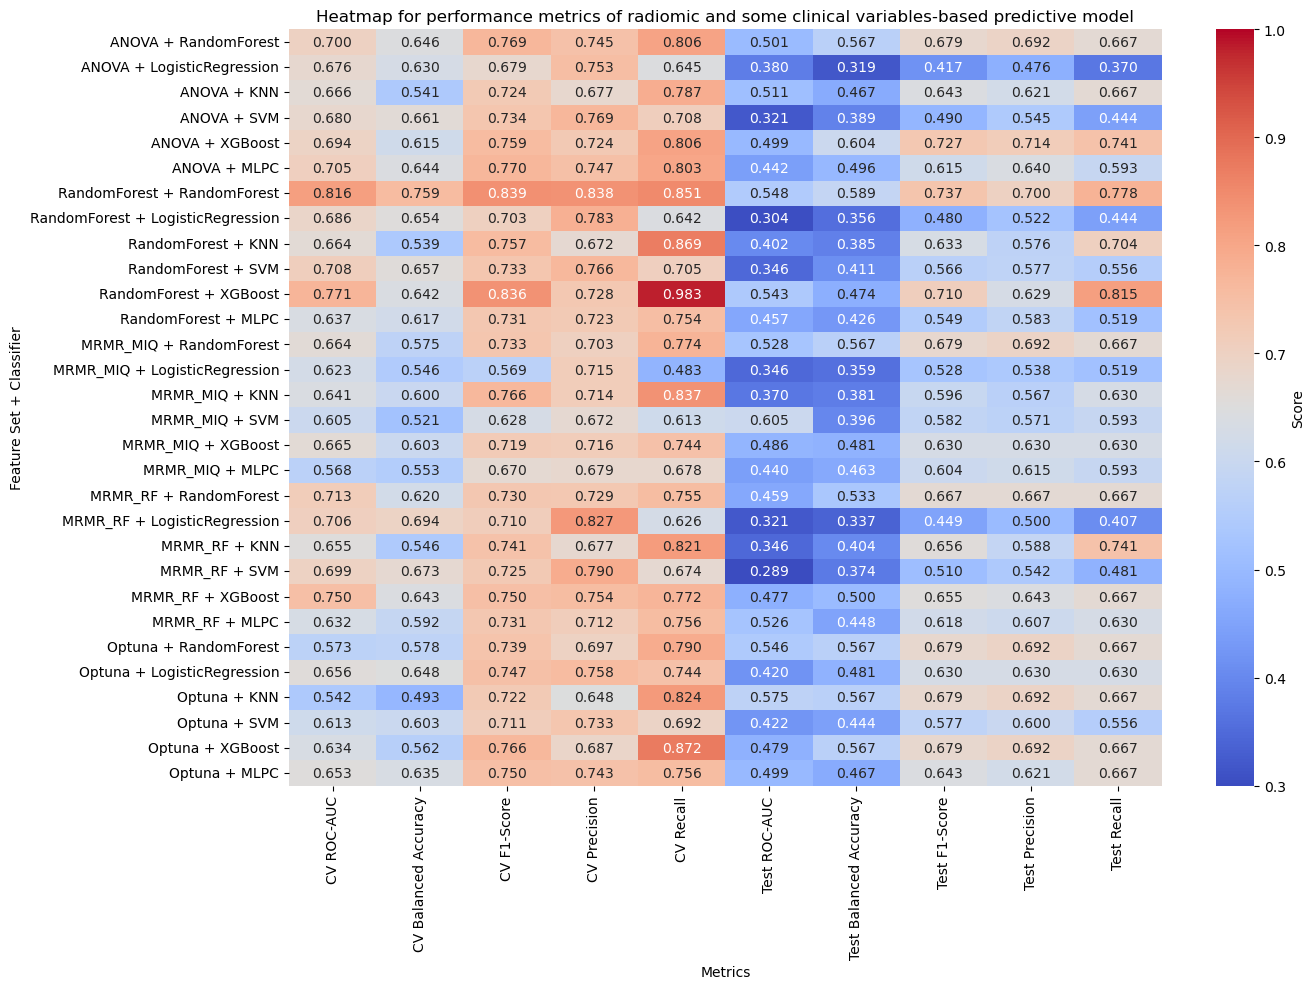

In [51]:
# Select the key metrics for the heatmap
metrics = ['CV ROC-AUC', 'CV Balanced Accuracy', 'CV F1-Score', 'CV Precision', 'CV Recall', 
           'Test ROC-AUC','Test Balanced Accuracy', 'Test F1-Score','Test Precision', 'Test Recall']

# Create a combined column with 'Feature_Set' and 'Classifier'
results_df['Model'] = results_df['Feature_Set'] + ' + ' + results_df['Classifier']

# Filter the metrics and set the new 'Model' column as the index
heatmap_data = results_df[metrics + ['Model']].set_index('Model')

# Generate the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".3f", cbar_kws={'label': 'Score'}, vmin=0.3, vmax=1)
plt.title('Heatmap for performance metrics of radiomic and some clinical variables-based predictive model')
plt.ylabel('Feature Set + Classifier')
plt.xlabel('Metrics')
plt.tight_layout()
plt.show()

# Balanced clinical and radiomic data models - Optuna hyperparameter tunning

## Training and testing

In [61]:
# Define classifiers
clfs = {
    'RandomForest': RandomForestClassifier(random_state=2024, class_weight="balanced"),
    'LogisticRegression': LogisticRegression(random_state=2024, max_iter=1000, class_weight="balanced"),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True, random_state=2024, class_weight="balanced"),
    'XGBoost': xgb.XGBClassifier(objective="binary:logistic", random_state=2024),
    'MLPC': MLPClassifier(random_state=2024)
}

scoring = {
    'roc_auc': 'roc_auc',
    'balanced_accuracy': make_scorer(balanced_accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

# Define the objective function for Optuna
def objective(trial, clf_name, X_train, y_train, cv):
    # Hyperparameter search space for each model
    if clf_name == 'RandomForest':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 200),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
            'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
        }
        model = RandomForestClassifier(random_state=2024, class_weight="balanced", **params)

    elif clf_name == 'LogisticRegression':
        params = {
            'C': trial.suggest_float('C', 0.01, 10),
            'solver': trial.suggest_categorical('solver', ['liblinear']),
            'penalty': trial.suggest_categorical('penalty', ['l1', 'l2'])
        }
        model = LogisticRegression(random_state=2024, max_iter=1000, class_weight="balanced", **params)

    elif clf_name == 'KNN':
        params = {
            'n_neighbors': trial.suggest_int('n_neighbors', 3, 10),
            'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
            'metric': trial.suggest_categorical('metric', ['euclidean', 'manhattan'])
        }
        model = KNeighborsClassifier(**params)

    elif clf_name == 'SVM':
        params = {
            'C': trial.suggest_categorical('C', [0.1, 1, 10, 100]),
            'kernel': trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly']),
            'gamma': trial.suggest_categorical('gamma', ['scale', 'auto'])
        }
        model = SVC(probability=True, random_state=2024, class_weight="balanced", **params)

    elif clf_name == 'XGBoost':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 200),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0)
        }
        model = xgb.XGBClassifier(objective="binary:logistic", random_state=2024, **params)

    elif clf_name == 'MLPC':
        params = {
            'hidden_layer_sizes': trial.suggest_categorical('hidden_layer_sizes', [(50, 30), (30, 20), (20,)]),
            'max_iter': trial.suggest_categorical('max_iter', [100, 200, 300]),
            'activation': trial.suggest_categorical('activation', ['relu', 'logistic']),
            'solver': trial.suggest_categorical('solver', ['adam', 'lbfgs']),
            'alpha': trial.suggest_categorical('alpha', [0.0001, 0.001]),
            'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'adaptive']),
            'early_stopping': trial.suggest_categorical('early_stopping', [True])
        }
        model = MLPClassifier(random_state=2024, **params)

    # Perform cross-validation to evaluate the model
    cv_scores = []
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_train_fold, y_train_fold)
        y_pred_prob = model.predict_proba(X_val_fold)[:, 1]
        auc = roc_auc_score(y_val_fold, y_pred_prob)
        cv_scores.append(auc)

    # Return the mean cross-validated ROC-AUC score
    return np.mean(cv_scores)

# Define the Optuna optimization loop
def optimize_model(clf_name, X_train, y_train, cv):
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, clf_name, X_train, y_train, cv), n_trials=50)
    return study.best_trial

# Create Stratified K-Fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2024)

# Iterate through classifiers and feature sets
results = []
with open('radiomic_feature_sets.pkl', 'rb') as f:
    radiomic_feature_sets = pickle.load(f)

for feature_set_name, selected_features in radiomic_feature_sets.items():
    if len(selected_features) != 0:
        additional_features = list(set(selected_by_majority.index) - set(selected_features))  # Exclude duplicates
        to_select = list(selected_features) + additional_features
        X_train = x_train[to_select]
        X_test = x_test[to_select]

        for clf_name in clfs.keys():
            best_trial = optimize_model(clf_name, X_train, y_train, cv)
            best_params = best_trial.params
            clf = clfs[clf_name].set_params(**best_params)

            # Re-do cross-validation with the best model
            cv_results = cross_validate(
                clf, X_train, y_train, scoring=scoring, cv=cv, return_train_score=True
            )

            # Predictions on the test set
            clf.fit(X_train, y_train)
            y_pred_prob = clf.predict_proba(X_test)[:, 1]
            y_pred_test = clf.predict(X_test)

            # Store results
            results.append({
                'Feature_Set': feature_set_name,
                'Classifier': clf_name,
                'Best Params': best_params,
                'y_pred_prob': y_pred_prob,
                'y_pred_test': y_pred_test,
                'CV ROC-AUC': cv_results['test_roc_auc'].mean(),
                'CV ROC-AUC (std)': cv_results['test_roc_auc'].std(),
                'CV Balanced Accuracy': cv_results['test_balanced_accuracy'].mean(),
                'CV Precision': cv_results['test_precision'].mean(),
                'CV Recall': cv_results['test_recall'].mean(),
                'CV F1-Score': cv_results['test_f1'].mean(),
                'Test ROC-AUC': roc_auc_score(y_test, y_pred_prob),
                'Test Balanced Accuracy': balanced_accuracy_score(y_test, y_pred_test),
                'Test Precision': precision_score(y_test, y_pred_test),
                'Test Recall': recall_score(y_test, y_pred_test),
                'Test F1-Score': f1_score(y_test, y_pred_test),
            })

# Convert results to DataFrame and save
results_df = pd.DataFrame(results)
with open('RadiomicClinical_Optuna_results_df.pkl', 'wb') as f:
    pickle.dump(results_df, f)

[I 2024-12-31 02:08:23,498] A new study created in memory with name: no-name-900ebe9f-4db6-4b42-bfdd-e8d0eacad04f
[I 2024-12-31 02:08:24,092] Trial 0 finished with value: 0.6921245421245421 and parameters: {'n_estimators': 157, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 4, 'bootstrap': False}. Best is trial 0 with value: 0.6921245421245421.
[I 2024-12-31 02:08:24,479] Trial 1 finished with value: 0.6452380952380953 and parameters: {'n_estimators': 94, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 0 with value: 0.6921245421245421.
[I 2024-12-31 02:08:25,060] Trial 2 finished with value: 0.6798534798534799 and parameters: {'n_estimators': 147, 'max_depth': 14, 'min_samples_split': 10, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 0 with value: 0.6921245421245421.
[I 2024-12-31 02:08:25,842] Trial 3 finished with value: 0.6968864468864469 and parameters: {'n_estimators': 176, 'max_depth': 9, 'min_samples_sp

#### Results table

In [26]:
with open('RadiomicClinical_Optuna_results_df.pkl', 'rb') as f:
    results_df = pickle.load(f)

# Sort the table by Test ROC-AUC
sorted_results_df = results_df.sort_values(by='Test ROC-AUC', ascending=False)

# Select important columns for display
columns_to_display = [
    'Feature_Set', 'Classifier', 'Best Params', 'CV ROC-AUC', 'CV ROC-AUC (std)', 'CV Balanced Accuracy', 'CV Precision',
     'CV Recall','CV F1-Score','Test Balanced Accuracy', 'Test Precision', 
    'Test Recall', 'Test F1-Score', 'Test ROC-AUC'
]

# Filter and display
results_table = sorted_results_df[columns_to_display].round(3)

# Display the table (top 10 rows)
display(results_table.head(10))
results_table.to_excel('SOMEclinicalANDradiomic_model_results_Optuna.xlsx', index=False)

Feature_Set    Classifier  \
15      MRMR_MIQ           SVM   
17      MRMR_MIQ          MLPC   
24        Optuna  RandomForest   
11  RandomForest          MLPC   
26        Optuna           KNN   
6   RandomForest  RandomForest   
10  RandomForest       XGBoost   
4          ANOVA       XGBoost   
2          ANOVA           KNN   
0          ANOVA  RandomForest   

                                          Best Params  CV ROC-AUC  \
15     {'C': 100, 'kernel': 'poly', 'gamma': 'scale'}       0.444   
17  {'hidden_layer_sizes': (20,), 'max_iter': 300,...       0.528   
24  {'n_estimators': 66, 'max_depth': 10, 'min_sam...       0.579   
11  {'hidden_layer_sizes': (30, 20), 'max_iter': 2...       0.613   
26  {'n_neighbors': 10, 'weights': 'distance', 'me...       0.564   
6   {'n_estimators': 89, 'max_depth': 9, 'min_samp...       0.811   
10  {'n_estimators': 125, 'learning_rate': 0.03037...       0.766   
4   {'n_estimators': 50, 'learning_rate': 0.066799...       0.711   
2   {'n_neighbors': 4, 'weights': 'distance', 'met...       0.666   
0   {'n_estimators': 146, 'max_depth': 3, 'min_sam...       0.714   

    CV ROC-AUC (std)  CV Balanced Accuracy  CV Precision  CV Recall  \
15             0.117                 0.516         0.665      0.579   
17             0.091                 0.500         0.000      0.000   
24             0.092                 0.554         0.683      0.837   
11             0.150                 0.604         0.734      0.722   
26             0.173                 0.501         0.653      0.806   
6              0.087                 0.711         0.798      0.818   
10             0.116                 0.643         0.745      0.868   
4              0.127                 0.625         0.728      0.855   
2              0.088                 0.541         0.677      0.787   
0              0.095                 0.638         0.739      0.791   

    CV F1-Score  Test Balanced Accuracy  Test Precision  Test Recall  \
15        0.611                   0.352           0.500        0.370   
17        0.000                   0.500           0.000        0.000   
24        0.752                   0.567           0.692        0.667   
11        0.721                   0.589           0.700        0.778   
26        0.718                   0.567           0.692        0.667   
6         0.799                   0.570           0.690        0.741   
10        0.798                   0.537           0.667        0.741   
4         0.783                   0.604           0.714        0.741   
2         0.724                   0.467           0.621        0.667   
0         0.757                   0.600           0.720        0.667   

    Test F1-Score  Test ROC-AUC  
15          0.426         0.674  
17          0.000         0.652  
24          0.679         0.569  
11          0.737         0.562  
26          0.679         0.560  
6           0.714         0.538  
10          0.702         0.531  
4           0.727         0.523  
2           0.643         0.511  
0           0.692         0.504

### ROC curves

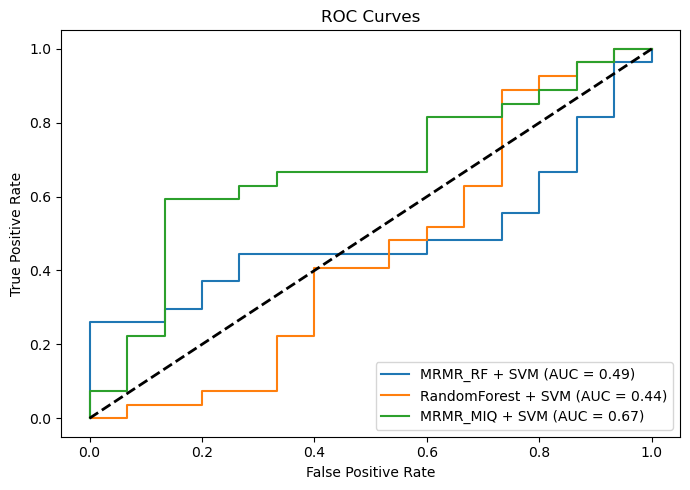

In [63]:
# Select the best models (SVM y los Feature Sets MRM_RF, RF, MRMR_MIQ)
top_models = results_df[(results_df['Classifier'] == 'SVM') & 
                        (results_df['Feature_Set'].isin(['MRMR_RF', 'RandomForest', 'MRMR_MIQ']))]

# Sort the models by the desired order of feature sets
feature_set_order = ['MRMR_RF', 'RandomForest', 'MRMR_MIQ']
top_models = top_models[top_models['Feature_Set'].isin(feature_set_order)]
top_models['Feature_Set'] = pd.Categorical(top_models['Feature_Set'], categories=feature_set_order, ordered=True)
top_models = top_models.sort_values('Feature_Set')

# Create a figure for the ROC curves
plt.figure(figsize=(7, 5))

# Generate ROC curves for the top models
for index, model in top_models.iterrows():
    clf_name = model['Classifier']
    feature_set_name = model['Feature_Set']
    y_pred_prob = model['y_pred_prob']  

    # Calculate ROC curve points (False Positive Rate, True Positive Rate)
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve for the current model
    plt.plot(fpr, tpr, label=f"{feature_set_name} + {clf_name} (AUC = {roc_auc:.2f})")

# Add a reference diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Add labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


### Precision Recall curves

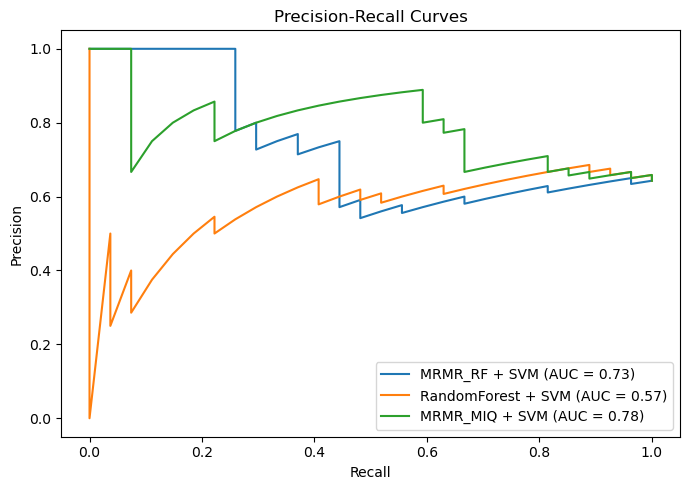

In [64]:
# Select the best models(SVM y los Feature Sets MRM_RF, RF, MRMR_MIQ)
top_models = results_df[(results_df['Classifier'] == 'SVM') & 
                        (results_df['Feature_Set'].isin(['MRMR_RF', 'RandomForest', 'MRMR_MIQ']))]

# Sort the models by the desired order of feature sets
feature_set_order = ['MRMR_RF', 'RandomForest', 'MRMR_MIQ']
top_models = top_models[top_models['Feature_Set'].isin(feature_set_order)]
top_models['Feature_Set'] = pd.Categorical(top_models['Feature_Set'], categories=feature_set_order, ordered=True)
top_models = top_models.sort_values('Feature_Set')

# Create a figure for the Precision-Recall curves
plt.figure(figsize=(7, 5))

# Generate Precision-Recall curves for the top models
for index, model in top_models.iterrows():
    feature_set = model['Feature_Set']
    clf_name = model['Classifier']
    y_pred_prob = model['y_pred_prob'] 

    # Calculate Precision and Recall values for the curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
    pr_auc = auc(recall, precision)

    # Plot the Precision-Recall curve for the current model
    plt.plot(recall, precision, label=f"{feature_set} + {clf_name} (AUC = {pr_auc:.2f})")

# Configure the plot labels and title
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="lower right")  
plt.tight_layout()
plt.show()


### Confusion Matrices

#### Standard CM

  Feature Selector Classifier Balanced Accuracy F1 Score Precision Recall
0          MRMR_RF        SVM              0.50     0.78      0.64   1.00
1     RandomForest        SVM              0.50     0.78      0.64   1.00
2         MRMR_MIQ        SVM              0.50     0.78      0.64   1.00


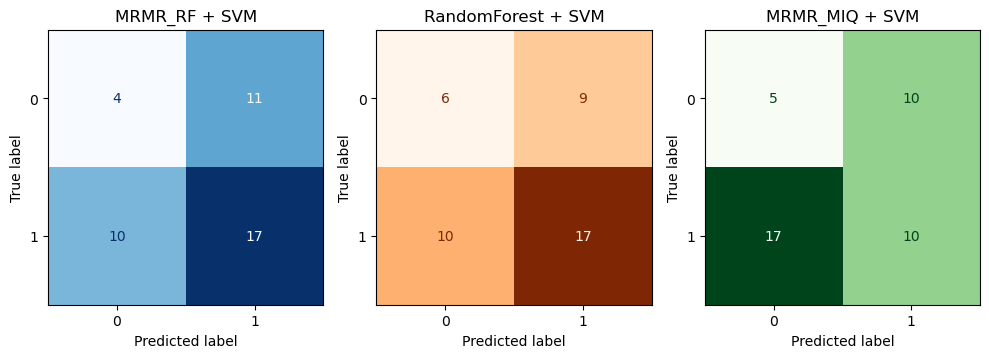

In [24]:
# Load the results dataframe from a pickle file
with open('RadiomicClinical_Optuna_results_df.pkl', 'rb') as f:
    results_df = pickle.load(f)

# DataFrame to store the results
metrics_data = []

# Select the top 3 models (SVM y los Feature Sets MRM_RF, RF, MRMR_MIQ)
top_models = results_df[(results_df['Classifier'] == 'SVM') & 
                        (results_df['Feature_Set'].isin(['MRMR_RF', 'RandomForest', 'MRMR_MIQ']))]

# Reorder models
feature_set_order = ['MRMR_RF', 'RandomForest', 'MRMR_MIQ']
top_models = top_models[top_models['Feature_Set'].isin(feature_set_order)]
top_models['Feature_Set'] = pd.Categorical(top_models['Feature_Set'], categories=feature_set_order, ordered=True)
top_models = top_models.sort_values('Feature_Set')

# Create a figure with 3 subplots in a single row
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

# Define custom color schemes for each confusion matrix
color_maps = ['Blues', 'Oranges', 'Greens']  # Colores distintos para cada una

# Generate confusion matrices for the top models
for ax, (_, model), cmap in zip(axes, top_models.iterrows(), color_maps):
    # Extract the feature set name, classifier name, and the model's test predictions
    feature_set = model['Feature_Set']
    clf_name = model['Classifier']
    y_pred_test = model['y_pred_test']  # Asegúrate de que esto esté en 'results_df'

    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred_test)
    
    # Plot the confusion matrix with the respective color map
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, cmap=cmap, colorbar=False)  # Asignar un cmap diferente por modelo
    
    # Set the title of the subplot
    ax.set_title(f"{feature_set} + {clf_name}")

    # Compute additional metrics
    balanced_acc = balanced_accuracy_score(y_test, y_pred_adjusted)
    f1 = f1_score(y_test, y_pred_adjusted)
    precision = precision_score(y_test, y_pred_adjusted)
    recall = recall_score(y_test, y_pred_adjusted)
    
    # Store the results in the metrics data list
    metrics_data.append({
        "Feature Selector": feature_set,
        "Classifier": clf_name,
        "Balanced Accuracy": f"{balanced_acc:.2f}",
        "F1 Score": f"{f1:.2f}",
        "Precision": f"{precision:.2f}",
        "Recall": f"{recall:.2f}"
    })

# Create a DataFrame with the collected metrics data
metrics_df = pd.DataFrame(metrics_data)
print(metrics_df)

# Adjust the layout of the figure
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajustar para no solapar el título
plt.show()

#### Youden CM

  Feature Selector Classifier Balanced Accuracy F1 Score Precision Recall
0          MRMR_RF        SVM              0.63     0.41      1.00   0.26
1     RandomForest        SVM              0.58     0.77      0.69   0.89
2         MRMR_MIQ        SVM              0.73     0.71      0.89   0.59


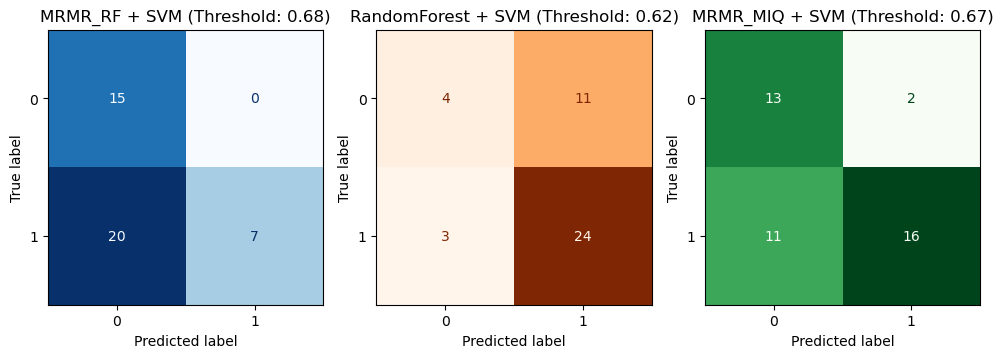

In [25]:
with open('RadiomicClinical_Optuna_results_df.pkl', 'rb') as f:
    results_df = pickle.load(f)

# DataFrame to store the results
metrics_data = []

# Seleccionar los mejores modelos (SVM y los Feature Sets MRM_RF, RF, MRMR_MIQ)
top_models = results_df[(results_df['Classifier'] == 'SVM') & 
                        (results_df['Feature_Set'].isin(['MRMR_RF', 'RandomForest', 'MRMR_MIQ']))]

# Ordenar los modelos por el orden deseado
feature_set_order = ['MRMR_RF', 'RandomForest', 'MRMR_MIQ']
top_models = top_models[top_models['Feature_Set'].isin(feature_set_order)]
top_models['Feature_Set'] = pd.Categorical(top_models['Feature_Set'], categories=feature_set_order, ordered=True)
top_models = top_models.sort_values('Feature_Set')

# Crear figura con 3 subplots en una sola fila
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

# Esquemas de colores personalizados para cada matriz
color_maps = ['Blues', 'Oranges', 'Greens']  # Colores distintos para cada una

# Generar las matrices de confusión para los mejores modelos
for ax, (_, model), cmap in zip(axes, top_models.iterrows(), color_maps):
    # Extraer el nombre del modelo y las predicciones
    feature_set = model['Feature_Set']
    clf_name = model['Classifier']
    y_pred_prob = model['y_pred_prob']  # Asegúrate de que esto esté en 'results_df'
    
    # Calcular el Youden Index para diferentes umbrales
    fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_prob)
    youden_index = tpr - fpr  # Youden Index = Sensitivity + Specificity - 1
    best_threshold = thresholds_roc[np.argmax(youden_index)]  # Umbral óptimo según el Youden Index
    y_pred_adjusted = (y_pred_prob >= best_threshold).astype(int)  # Ajustar las predicciones

    # Calcular la matriz de confusión
    cm = confusion_matrix(y_test, y_pred_adjusted)
    
    # Visualizar la matriz de confusión con el esquema de colores correspondiente
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, cmap=cmap, colorbar=False)  # Asignar un cmap diferente por modelo
    
    # Configurar el título del subplot
    ax.set_title(f"{feature_set} + {clf_name} (Threshold: {best_threshold:.2f})")

    # Calcular métricas
    balanced_acc = balanced_accuracy_score(y_test, y_pred_adjusted)
    f1 = f1_score(y_test, y_pred_adjusted)
    precision = precision_score(y_test, y_pred_adjusted)
    recall = recall_score(y_test, y_pred_adjusted)
    
    # Almacenar los resultados en la lista
    metrics_data.append({
        "Feature Selector": feature_set,
        "Classifier": clf_name,
        "Balanced Accuracy": f"{balanced_acc:.2f}",
        "F1 Score": f"{f1:.2f}",
        "Precision": f"{precision:.2f}",
        "Recall": f"{recall:.2f}"
    })

# Crear un DataFrame con los resultados
metrics_df = pd.DataFrame(metrics_data)

# Mostrar la tabla de resultados
print(metrics_df)

# Ajustar el layout de la figura
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajustar para no solapar el título
plt.show()


#### F1-Score CM

C:\Users\pcbox\AppData\Local\Temp\ipykernel_20080\136445371.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_models['Feature_Set'] = pd.Categorical(top_models['Feature_Set'], categories=feature_set_order, ordered=True)


  Feature Selector Classifier Balanced Accuracy F1 Score Precision Recall
0          MRMR_RF        SVM              0.50     0.78      0.64   1.00
1     RandomForest        SVM              0.53     0.79      0.66   1.00
2         MRMR_MIQ        SVM              0.53     0.79      0.66   1.00


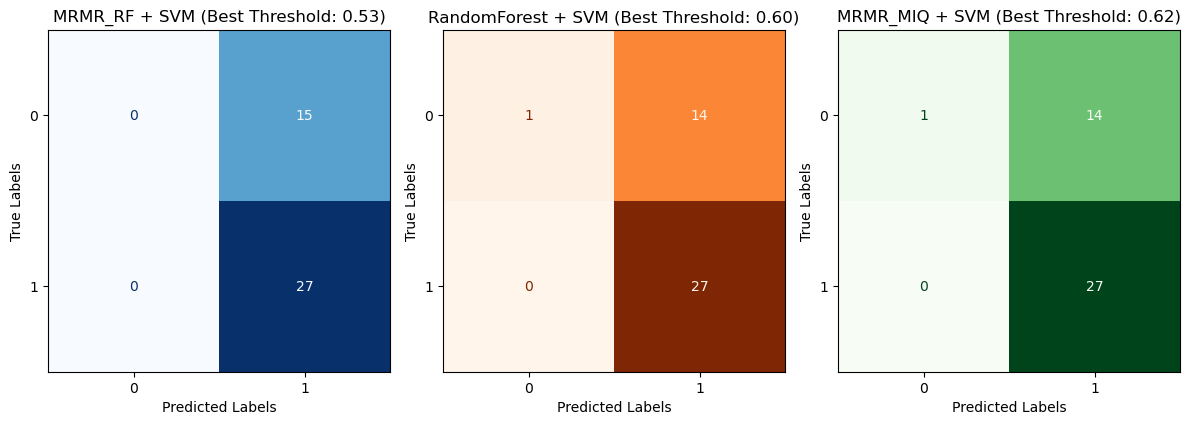

In [27]:
with open('RadiomicClinical_Optuna_results_df.pkl', 'rb') as f:
    results_df = pickle.load(f)

# DataFrame to store the results
metrics_data = []

# Select the best models (e.g., SVM with specific feature sets)
top_models = results_df[(results_df['Classifier'] == 'SVM') & 
                        (results_df['Feature_Set'].isin(['MRMR_RF', 'RandomForest', 'MRMR_MIQ']))]

# Sort models by feature set order
feature_set_order = ['MRMR_RF', 'RandomForest', 'MRMR_MIQ']
top_models['Feature_Set'] = pd.Categorical(top_models['Feature_Set'], categories=feature_set_order, ordered=True)
top_models = top_models.sort_values('Feature_Set')

# Create figure with 3 subplots in a single row
fig, axes = plt.subplots(1, 3, figsize=(12, 6))

# Color maps for each confusion matrix
color_maps = ['Blues', 'Oranges', 'Greens']

# Generate confusion matrices for the best models
for ax, (_, model), cmap in zip(axes, top_models.iterrows(), color_maps):
    feature_set = model['Feature_Set']
    clf_name = model['Classifier']
    y_pred_prob = model['y_pred_prob']

    # Compute F1 score for different thresholds to find the optimal threshold
    fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_prob)
    best_f1_score = 0
    best_threshold = 0

    # Iterate over the thresholds to find the one with the maximum F1 score
    for threshold in thresholds_roc:
        y_pred_adjusted = (y_pred_prob >= threshold).astype(int)
        score = f1_score(y_test, y_pred_adjusted)
        if score > best_f1_score:
            best_f1_score = score
            best_threshold = threshold

    # Adjust predictions with the best threshold
    y_pred_adjusted = (y_pred_prob >= best_threshold).astype(int)

    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred_adjusted)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, cmap=cmap, colorbar=False)

    # Set the title with the feature set, classifier name, and best threshold
    ax.set_title(f"{feature_set} + {clf_name} (Best Threshold: {best_threshold:.2f})")
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

      # Calcular métricas
    balanced_acc = balanced_accuracy_score(y_test, y_pred_adjusted)
    f1 = f1_score(y_test, y_pred_adjusted)
    precision = precision_score(y_test, y_pred_adjusted)
    recall = recall_score(y_test, y_pred_adjusted)
    
    # Almacenar los resultados en la lista
    metrics_data.append({
        "Feature Selector": feature_set,
        "Classifier": clf_name,
        "Balanced Accuracy": f"{balanced_acc:.2f}",
        "F1 Score": f"{f1:.2f}",
        "Precision": f"{precision:.2f}",
        "Recall": f"{recall:.2f}"
    })

# Crear un DataFrame con los resultados
metrics_df = pd.DataFrame(metrics_data)

# Mostrar la tabla de resultados
print(metrics_df)

# Adjust layout and show the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### Results Heatmap

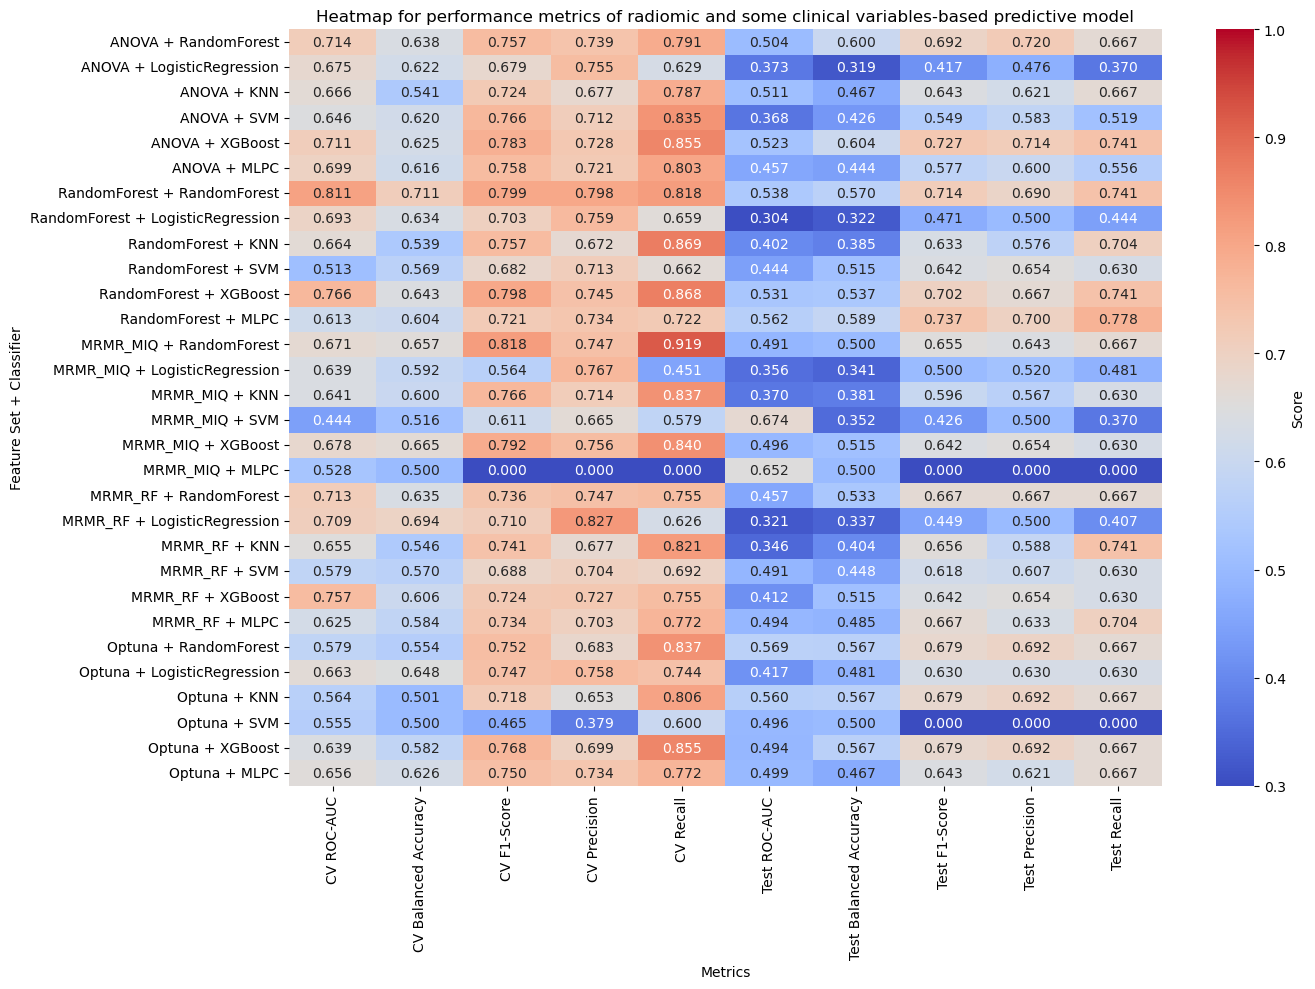

In [68]:
# Select key metrics to be included in the heatmap
metrics = ['CV ROC-AUC', 'CV Balanced Accuracy', 'CV F1-Score', 'CV Precision', 'CV Recall', 
           'Test ROC-AUC','Test Balanced Accuracy', 'Test F1-Score','Test Precision', 'Test Recall']

# Create a combined column for `Feature_Set` and `Classifier`
results_df['Model'] = results_df['Feature_Set'] + ' + ' + results_df['Classifier']

# Filter out the relevant metrics and set the 'Model' column as the index
heatmap_data = results_df[metrics + ['Model']].set_index('Model')

# Generate the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".3f", cbar_kws={'label': 'Score'}, vmin=0.3, vmax=1)
plt.title('Heatmap for performance metrics of radiomic and some clinical variables-based predictive model')
plt.ylabel('Feature Set + Classifier')
plt.xlabel('Metrics')
plt.tight_layout()
plt.show()